# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/Abilene-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'GRU'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'GRU_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'GRU_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time     OD_1-1      OD_1-2       OD_1-3      OD_1-4  \
0  2004-03-01-00-00  26.666667  522.208000  1641.338667  335.728000   
1  2004-03-01-00-05  26.666667  465.701333   868.098667  148.346667   
2  2004-03-01-00-10  53.333333  375.261333  1082.378667  276.136000   
3  2004-03-01-00-15  67.274667  498.360000  1332.205333  121.269333   
4  2004-03-01-00-20  26.666667  723.962667  1428.480000  165.938667   

       OD_1-5       OD_1-6      OD_1-7       OD_1-8      OD_1-9  ...  \
0  413.032000   489.874667  365.077333   817.869333  452.061333  ...   
1  398.701333  1821.269333  402.144000  1090.848000  585.202667  ...   
2  453.426667  1703.384000  407.152000   403.664000  853.005333  ...   
3  425.168000   794.472000  506.746667   142.328000  818.728000  ...   
4  459.965333   403.757333  303.256000   257.877333  848.208000  ...   

        OD_12-3       OD_12-4       OD_12-5       OD_12-6       OD_12-7  \
0  66541.197333  36063.421333  15439.312000  62781.813333  32642.733333   
1  62246.088000  34109.810667  15664.965333  56823.610667  24912.210667   
2  70181.930667  29905.896000  19918.581333  58658.568000  19036.714667   
3  74490.416000  44822.789333  16250.042667  50589.922667  18758.725333   
4  69881.266667  44536.856000  18448.840000  51095.165333  18614.133333   

         OD_12-8        OD_12-9     OD_12-10      OD_12-11       OD_12-12  
0   91675.626667  133661.405333  1980.576000  29760.202667  187653.482667  
1  100567.461333  137277.728000  4411.589333  30667.266667  190925.981333  
2   92415.480000  153845.554667  5300.653333  39990.880000  218742.773333  
3   97793.093333  159339.533333  4490.272000  38331.688000  265665.077333  
4   93446.560000  151623.424000  3487.808000  43462.373333  210540.786667  

[5 rows x 145 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2004-07-12 14:25:00', freq='5T')

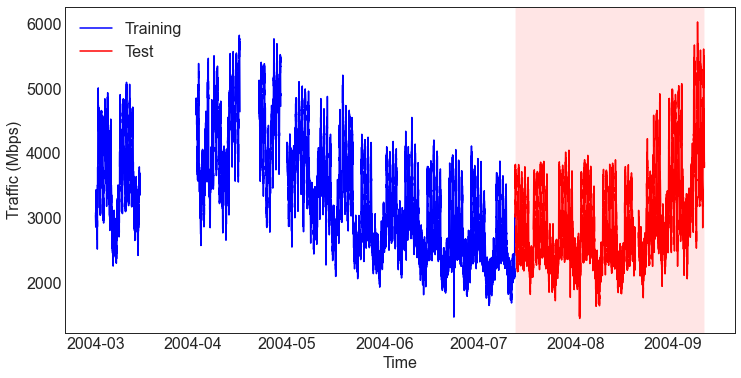

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

5.940447088662937


In [26]:
print(np.min(data.flatten()))

-0.0023245664896374284


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

48096


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(48086, 10, 144)

In [32]:
y_data.shape

(48086, 1, 144)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(48086, 144)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

38467

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

30773

In [40]:
valid_length

7694

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(30773, 144, 10)

In [43]:
y_train.shape

(30773, 144)

In [44]:
X_valid.shape

(7694, 144, 10)

In [45]:
y_valid.shape

(7694, 144)

In [46]:
X_test.shape

(9619, 144, 10)

In [47]:
y_test.shape

(9619, 144)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(38467, 144, 10)

In [50]:
y.shape

(38467, 144)

In [51]:
splits

((#30773) [0,1,2,3,4,5,6,7,8,9...],
 (#7694) [30773,30774,30775,30776,30777,30778,30779,30780,30781,30782...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#38467) [(TSTensor(vars:144, len:10), tensor([2.0469e-03, 5.1440e-02, 1.4299e-01, 1.5172e-02, 3.1831e-02, 2.1060e-02,
        5.6545e-02, 2.7428e-02, 2.8036e-01, 0.0000e+00, 4.0722e-02, 8.6615e-02,
        5.2351e-02, 2.0172e-01, 2.2308e-01, 5.7753e-02, 2.0265e-02, 1.5293e-01,
        9.8783e-02, 1.2363e-01, 1.7657e-01, 3.3181e-02, 2.1478e-01, 3.0738e-01,
        9.3064e-02, 9.6376e-02, 1.5660e-01, 3.1830e-02, 4.6944e-02, 1.3623e-01,
        4.7996e-02, 9.0038e-02, 3.8663e-02, 3.1614e-02, 1.1989e-01, 4.8892e-02,
        7.9847e-03, 2.8893e-02, 1.8501e-01, 3.5594e-02, 1.7775e-02, 6.8981e-02,
        8.2558e-02, 8.7485e-02, 1.3270e-01, 7.0169e-02, 1.0452e-01, 2.8641e-02,
        2.3876e-01, 3.3501e-02, 1.7263e-01, 9.0359e-02, 4.2771e-02, 4.5059e-01,
        2.0892e-01, 1.9877e-02, 5.5563e-02, 1.0113e-01, 1.0701e-01, 3.5482e-02,
        1.2049e-01, 1.0425e-01, 4.3749e-01, 9.8969e-02, 7.4077e-02, 9.2987e-02,
        1.2642e-01, 1.1211e-01, 1.5237e-01, 7.5094e-02, 2.2026e-01, 1.6917e-01,
 

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "n_layers": hp.choice('n_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x2a7da884a08>,
 'lr': <hyperopt.pyll.base.Apply at 0x2a7da884588>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2a7da87e4c8>,
 'patience': <hyperopt.pyll.base.Apply at 0x2a7da87e8c8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2a7da87e488>,
 'n_layers': <hyperopt.pyll.base.Apply at 0x2a7da989808>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x2a7da92b048>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x2a7da972048>}

In [55]:
# clear memory 
gc.collect()

71

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = GRU
        k = {
            'n_layers': params['n_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 20, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
  0%|                                                                          | 0/100 [00:06<?, ?trial/s, best loss=?]

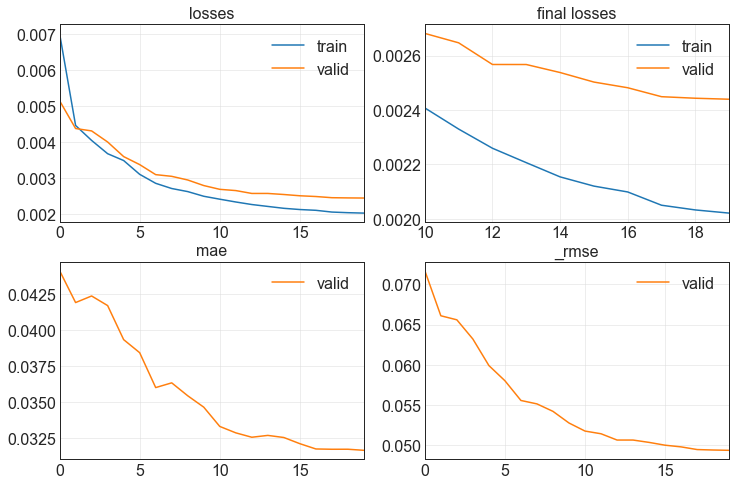

30.177067518234253                                                                                                     
[0.002021016785874963, 0.002439603442326188, 0.031675830483436584, 0.04939233511686325]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
  1%|▍                                           | 1/100 [00:41<1:01:00, 36.97s/trial, best loss: 0.002439603442326188]

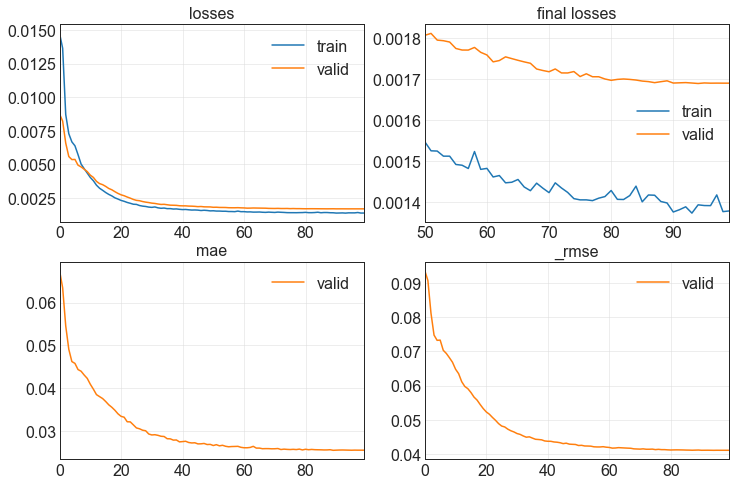

519.5090250968933                                                                                                      
[0.0013790159719064832, 0.0016906586242839694, 0.02550162933766842, 0.04111762344837189]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
  2%|▊                                         | 2/100 [09:25<4:59:06, 183.13s/trial, best loss: 0.0016906586242839694]

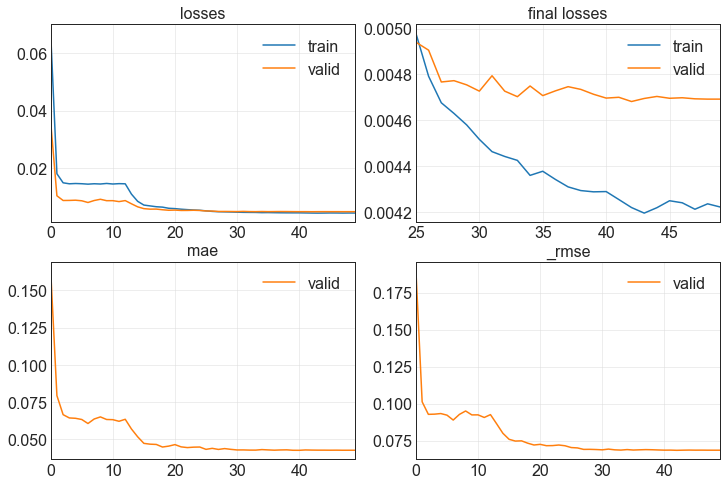

149.40218043327332                                                                                                     
[0.004220592323690653, 0.004692235961556435, 0.04273563623428345, 0.06849989295005798]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
  3%|█▎                                        | 3/100 [11:59<4:42:00, 174.44s/trial, best loss: 0.0016906586242839694]

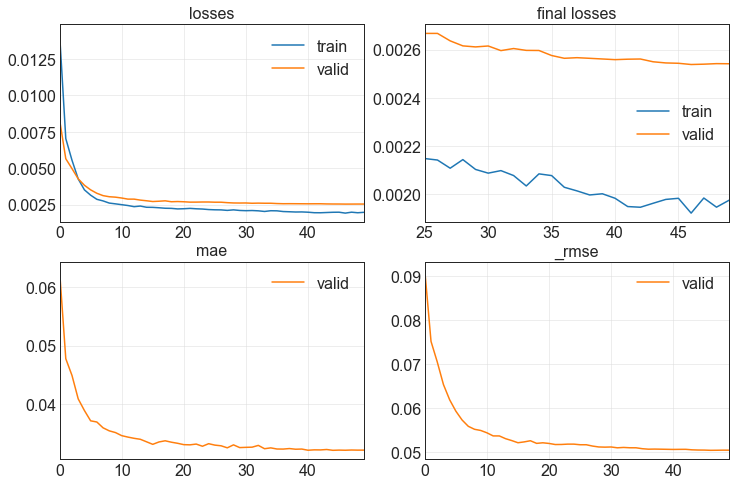

308.7861416339874                                                                                                      
[0.001974457176402211, 0.0025414966512471437, 0.032191161066293716, 0.050413258373737335]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
  4%|█▋                                        | 4/100 [17:13<5:45:48, 216.13s/trial, best loss: 0.0016906586242839694]

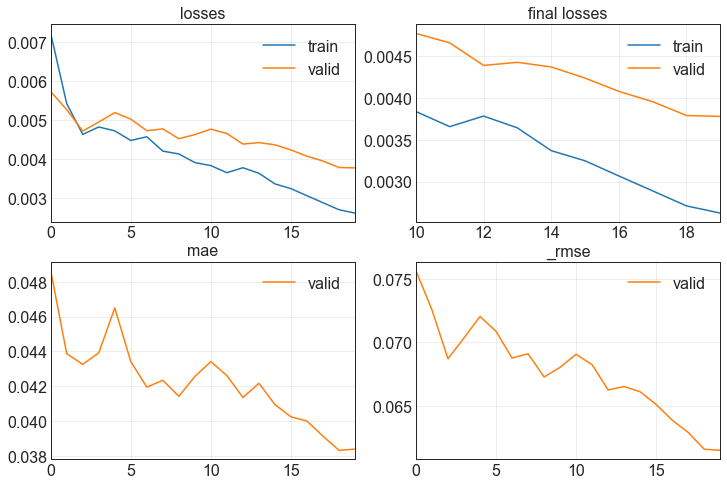

143.9396207332611                                                                                                      
[0.0026251226663589478, 0.00377928139641881, 0.03838159143924713, 0.061475854367017746]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
  5%|██                                        | 5/100 [19:42<5:10:09, 195.89s/trial, best loss: 0.0016906586242839694]

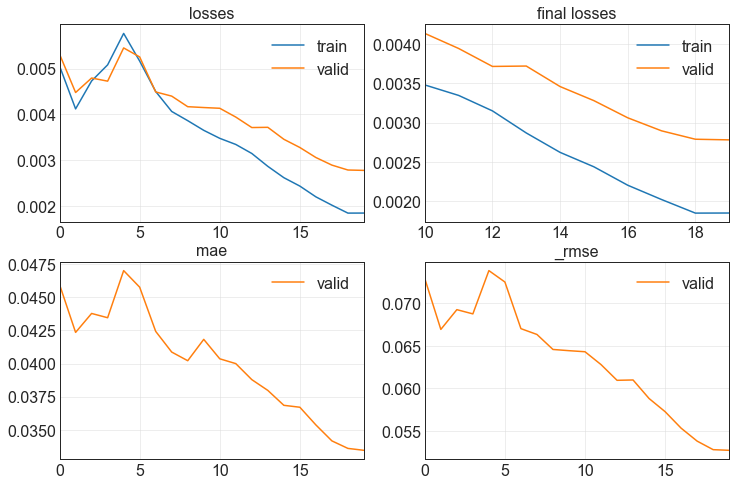

490.843293428421                                                                                                       
[0.0018474870594218373, 0.0027792397886514664, 0.03345136716961861, 0.05271849036216736]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
  6%|██▌                                       | 6/100 [27:57<7:27:52, 285.88s/trial, best loss: 0.0016906586242839694]

No improvement since epoch 66: early stopping                                                                          
  6%|██▌                                       | 6/100 [29:39<7:27:52, 285.88s/trial, best loss: 0.0016906586242839694]

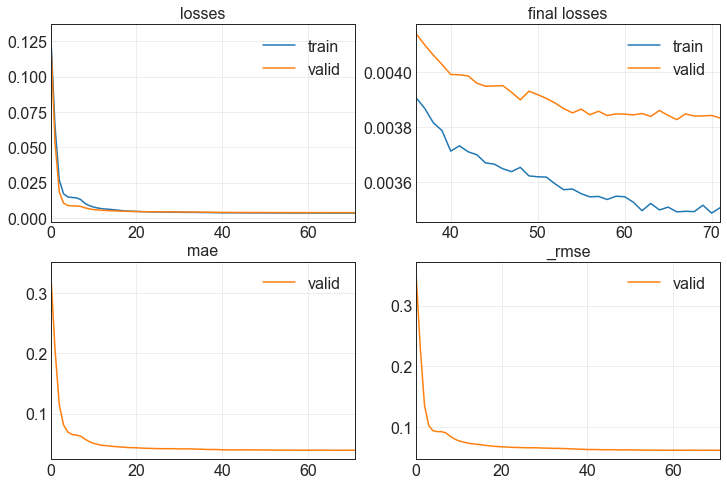

102.31770515441895                                                                                                     
[0.0035060271620750427, 0.003831828711554408, 0.039190467447042465, 0.0619017668068409]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
  7%|██▉                                       | 7/100 [29:44<5:59:59, 232.25s/trial, best loss: 0.0016906586242839694]

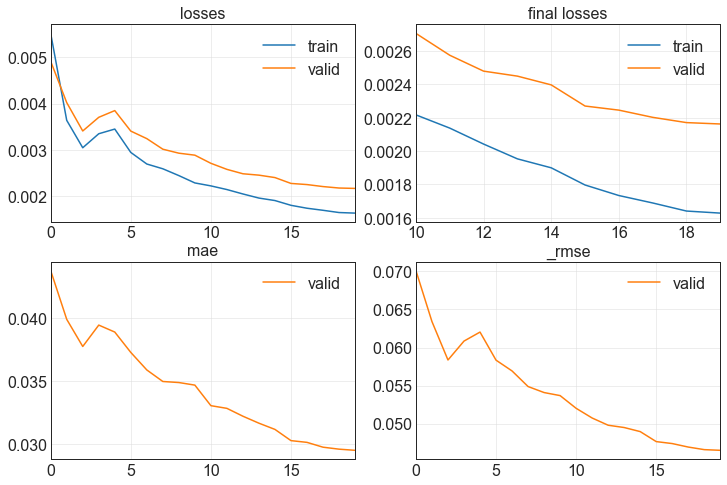

87.19045066833496                                                                                                      
[0.0016281522111967206, 0.0021628427784889936, 0.02950202487409115, 0.046506378799676895]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
  8%|███▎                                      | 8/100 [31:16<4:51:32, 190.14s/trial, best loss: 0.0016906586242839694]

No improvement since epoch 38: early stopping                                                                          
  8%|███▎                                      | 8/100 [54:43<4:51:32, 190.14s/trial, best loss: 0.0016906586242839694]

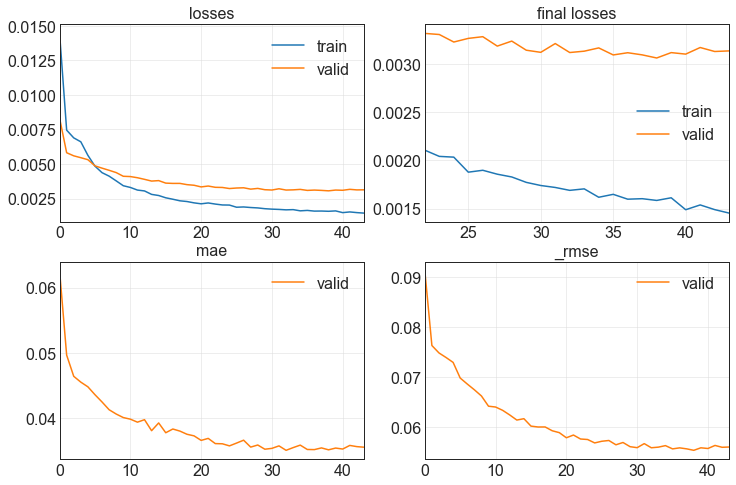

1407.0586504936218                                                                                                     
[0.001453613629564643, 0.0031374956015497446, 0.03558403626084328, 0.05601334944367409]                                
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
  9%|███▋                                     | 9/100 [54:48<14:04:11, 556.61s/trial, best loss: 0.0016906586242839694]

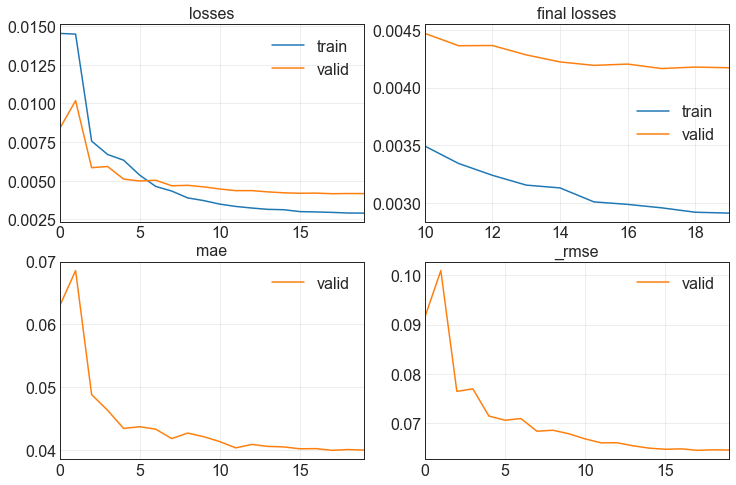

95.49884676933289                                                                                                      
[0.0029110026080161333, 0.004171862732619047, 0.03994810953736305, 0.0645899549126625]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 10%|████                                    | 10/100 [56:28<10:29:33, 419.71s/trial, best loss: 0.0016906586242839694]

No improvement since epoch 2: early stopping                                                                           
 10%|███▊                                  | 10/100 [1:00:31<10:29:33, 419.71s/trial, best loss: 0.0016906586242839694]

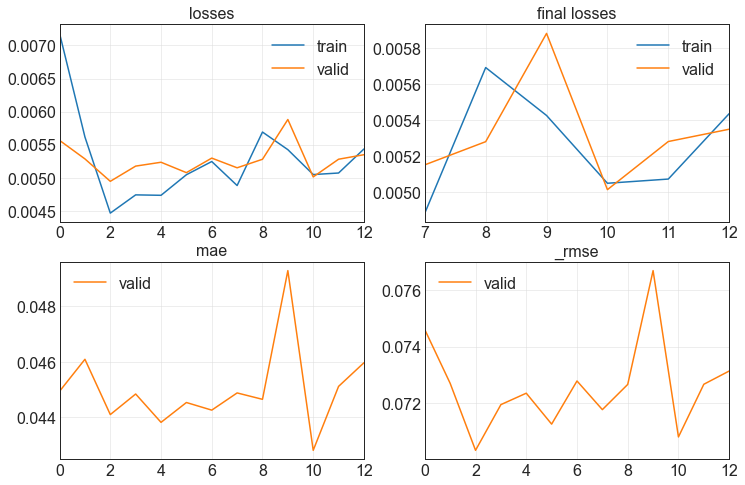

243.19423174858093                                                                                                     
[0.005435220431536436, 0.00534873316064477, 0.04596344381570816, 0.07313503324985504]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 11%|████▎                                  | 11/100 [1:00:36<9:06:04, 368.15s/trial, best loss: 0.0016906586242839694]

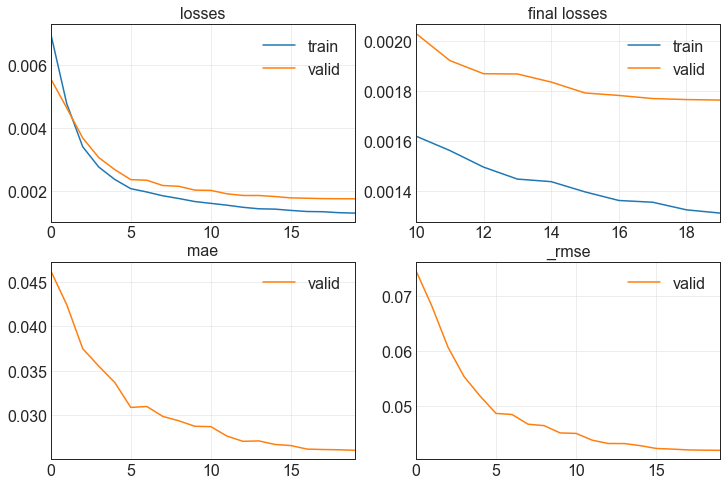

132.90434098243713                                                                                                     
[0.0013106728438287973, 0.0017631445080041885, 0.026065371930599213, 0.04198981821537018]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 12%|████▋                                  | 12/100 [1:02:54<7:18:29, 298.97s/trial, best loss: 0.0016906586242839694]

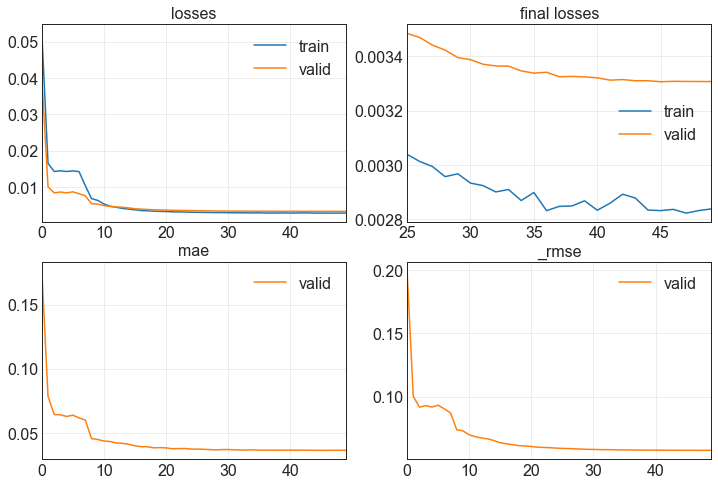

156.03170680999756                                                                                                     
[0.002838364103808999, 0.003306515049189329, 0.03646397590637207, 0.057502295821905136]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 13%|█████                                  | 13/100 [1:05:34<6:13:19, 257.47s/trial, best loss: 0.0016906586242839694]

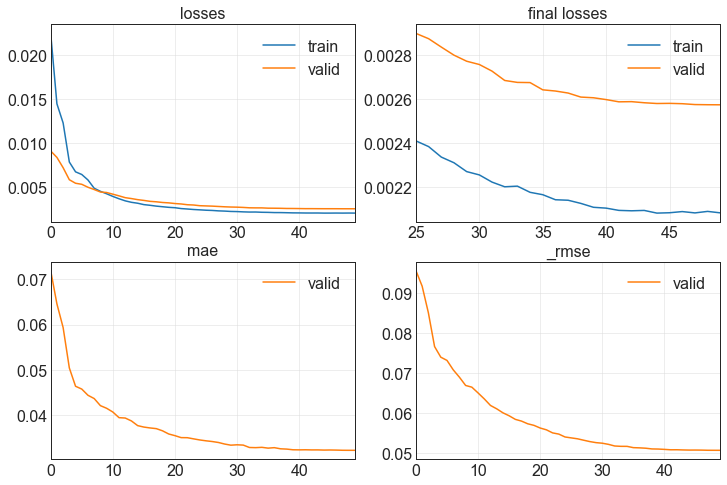

181.88232517242432                                                                                                     
[0.0020843124948441982, 0.0025754037778824568, 0.032164257019758224, 0.05074843391776085]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 14%|█████▍                                 | 14/100 [1:08:41<5:38:32, 236.19s/trial, best loss: 0.0016906586242839694]

No improvement since epoch 8: early stopping                                                                           
 14%|█████▍                                 | 14/100 [1:13:09<5:38:32, 236.19s/trial, best loss: 0.0016906586242839694]

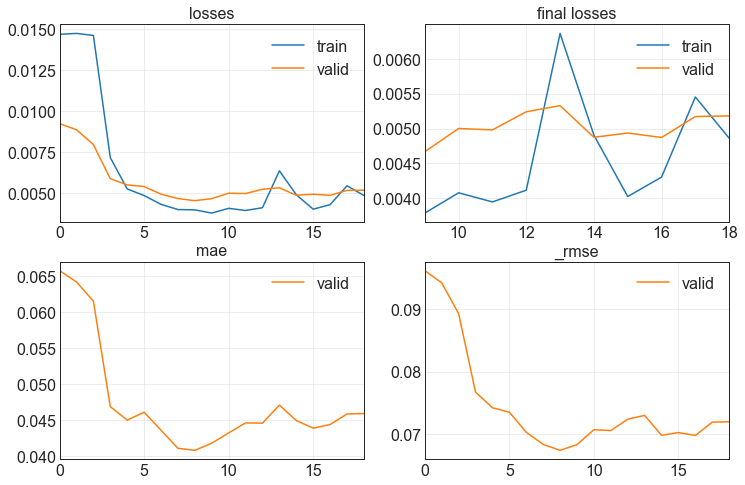

268.19520115852356                                                                                                     
[0.004860696382820606, 0.005181524436920881, 0.045871488749980927, 0.07198281586170197]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 15%|█████▊                                 | 15/100 [1:13:14<5:50:11, 247.19s/trial, best loss: 0.0016906586242839694]

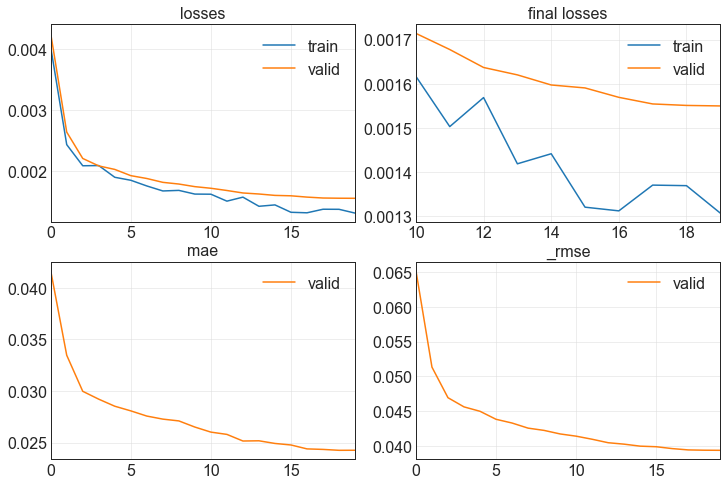

264.80785489082336                                                                                                     
[0.001306844293139875, 0.0015497802523896098, 0.024251850321888924, 0.03936725854873657]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 16%|██████▏                                | 16/100 [1:17:43<5:55:24, 253.86s/trial, best loss: 0.0015497802523896098]

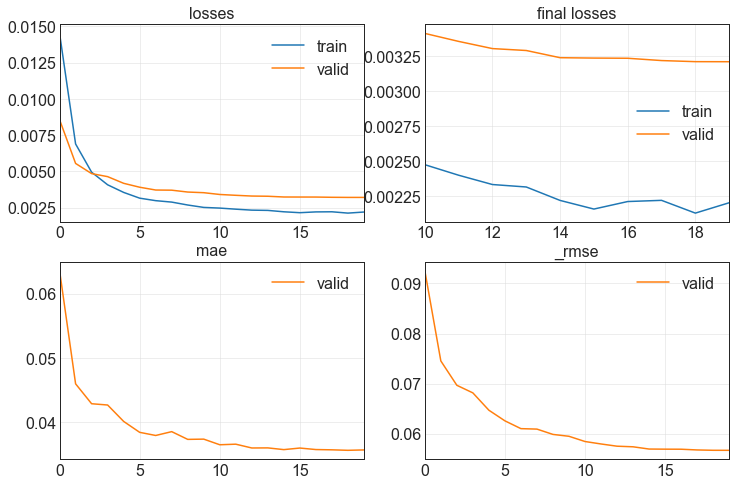

685.8354866504669                                                                                                      
[0.002200623508542776, 0.0032089564483612776, 0.03570391982793808, 0.0566476434469223]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 17%|██████▋                                | 17/100 [1:29:14<8:52:22, 384.85s/trial, best loss: 0.0015497802523896098]

No improvement since epoch 8: early stopping                                                                           
 17%|██████▋                                | 17/100 [1:30:11<8:52:22, 384.85s/trial, best loss: 0.0015497802523896098]

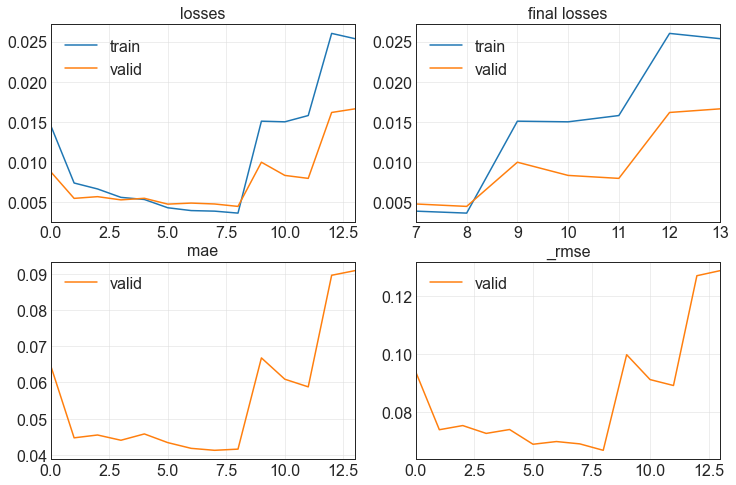

58.1397762298584                                                                                                       
[0.025371070951223373, 0.016618594527244568, 0.0908728688955307, 0.12891311943531036]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 18%|███████                                | 18/100 [1:30:16<6:33:55, 288.24s/trial, best loss: 0.0015497802523896098]

No improvement since epoch 4: early stopping                                                                           
 18%|███████                                | 18/100 [1:30:44<6:33:55, 288.24s/trial, best loss: 0.0015497802523896098]

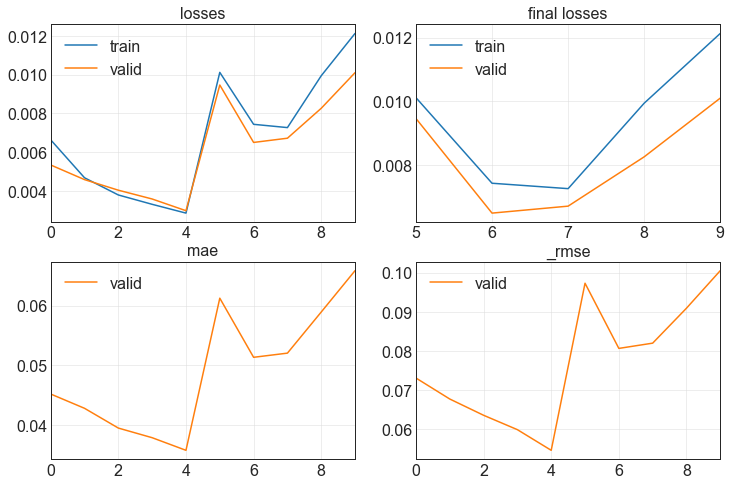

28.453232288360596                                                                                                     
[0.012130388990044594, 0.010105781257152557, 0.06585569679737091, 0.10052751749753952]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 19%|███████▍                               | 19/100 [1:30:50<4:45:46, 211.68s/trial, best loss: 0.0015497802523896098]

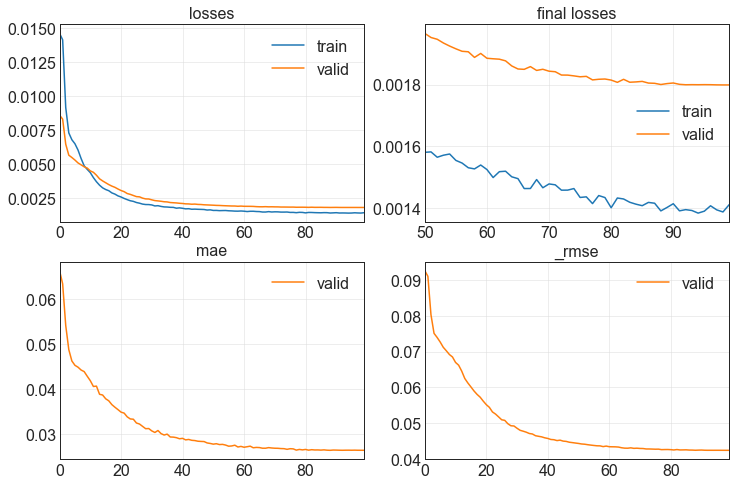

664.9503934383392                                                                                                      
[0.0014117761747911572, 0.0017989440821111202, 0.026411738246679306, 0.04241396114230156]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 20%|███████▊                               | 20/100 [1:41:59<7:45:24, 349.06s/trial, best loss: 0.0015497802523896098]

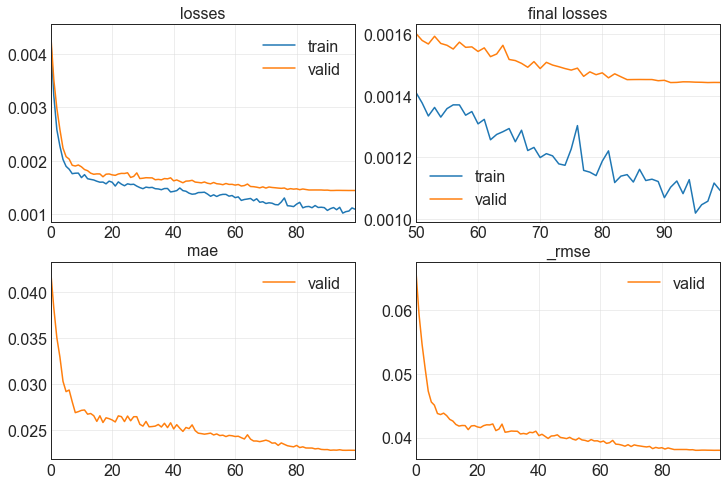

1274.4915113449097                                                                                                     
[0.0010918088955804706, 0.0014431083109229803, 0.022833339869976044, 0.03798826411366463]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 21%|███████▉                              | 21/100 [2:03:19<13:46:59, 628.09s/trial, best loss: 0.0014431083109229803]

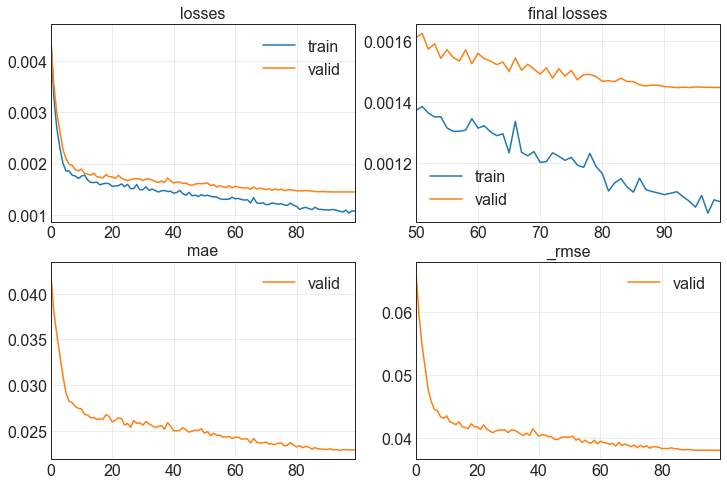

1275.6235444545746                                                                                                     
[0.0010730298236012459, 0.001447562943212688, 0.022919226437807083, 0.03804686293005943]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 22%|████████▎                             | 22/100 [2:24:39<17:50:58, 823.83s/trial, best loss: 0.0014431083109229803]

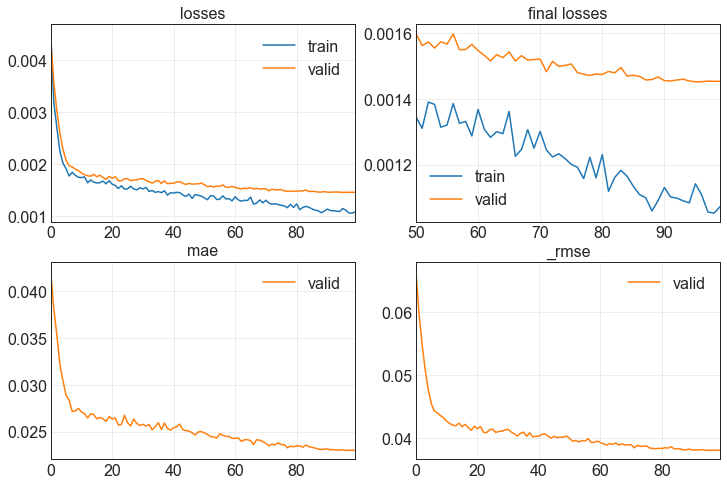

1297.403841972351                                                                                                      
[0.0010733621893450618, 0.0014529773034155369, 0.023007404059171677, 0.038117941468954086]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 23%|████████▋                             | 23/100 [2:46:22<20:41:27, 967.38s/trial, best loss: 0.0014431083109229803]

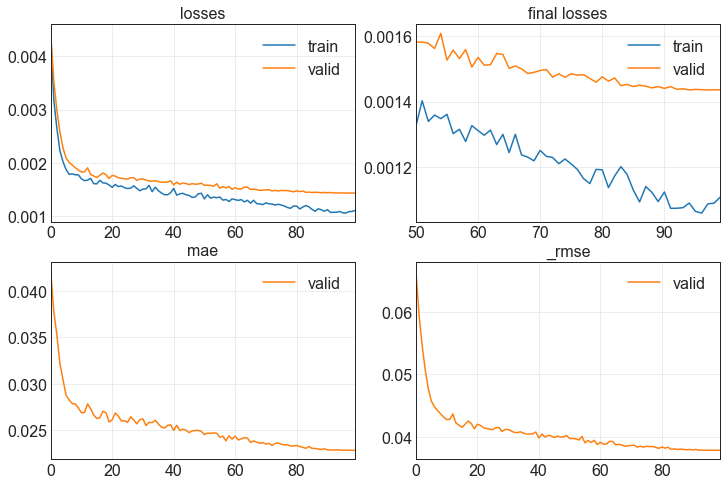

1318.6722762584686                                                                                                     
[0.0011075909715145826, 0.001435956102795899, 0.022839905694127083, 0.03789401054382324]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 24%|█████████                             | 24/100 [3:08:25<22:40:43, 1074.26s/trial, best loss: 0.001435956102795899]

No improvement since epoch 32: early stopping                                                                          
 24%|█████████                             | 24/100 [3:17:33<22:40:43, 1074.26s/trial, best loss: 0.001435956102795899]

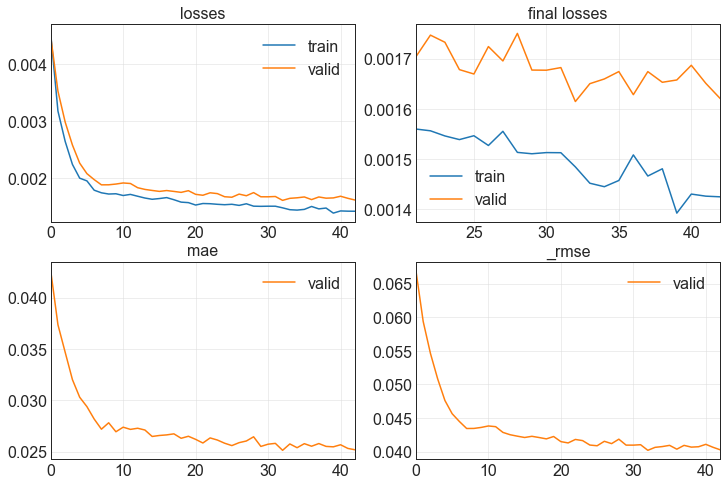

548.6343092918396                                                                                                      
[0.0014241974567994475, 0.001620116294361651, 0.025186456739902496, 0.040250666439533234]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 25%|█████████▊                             | 25/100 [3:17:38<19:07:33, 918.05s/trial, best loss: 0.001435956102795899]

No improvement since epoch 41: early stopping                                                                          
 25%|█████████▊                             | 25/100 [3:28:40<19:07:33, 918.05s/trial, best loss: 0.001435956102795899]

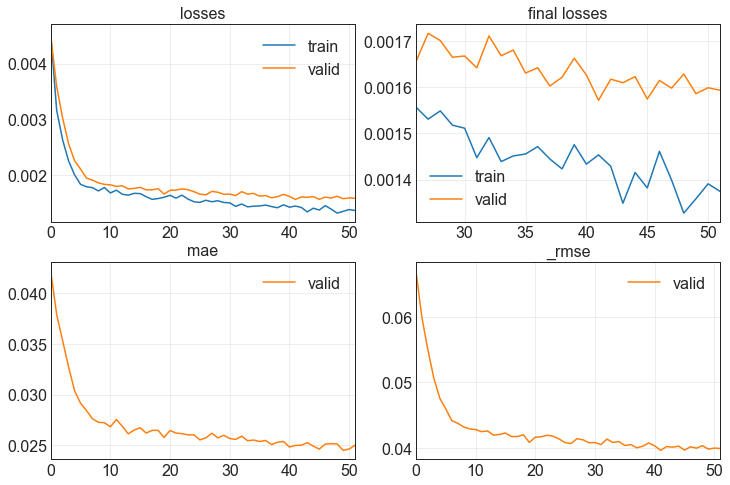

662.0677301883698                                                                                                      
[0.0013743374729529023, 0.0015930888475850224, 0.02500045858323574, 0.03991352394223213]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 26%|██████████▏                            | 26/100 [3:28:45<17:19:17, 842.67s/trial, best loss: 0.001435956102795899]

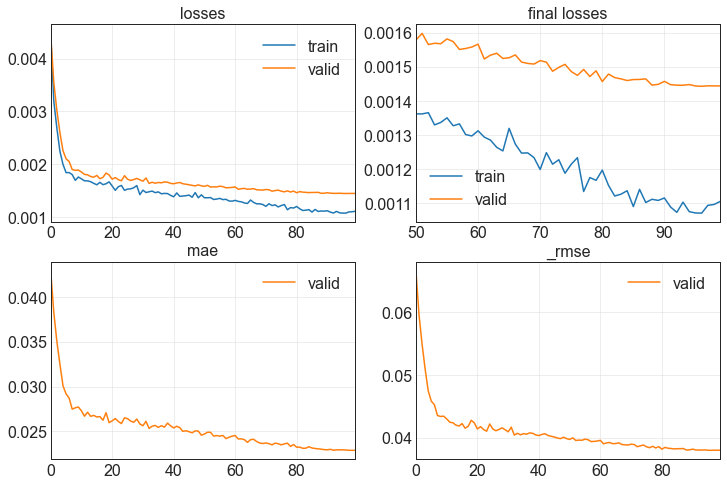

1282.808231830597                                                                                                      
[0.0011051761684939265, 0.0014434254262596369, 0.022904664278030396, 0.037992436438798904]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 27%|██████████▌                            | 27/100 [3:50:13<19:47:39, 976.15s/trial, best loss: 0.001435956102795899]

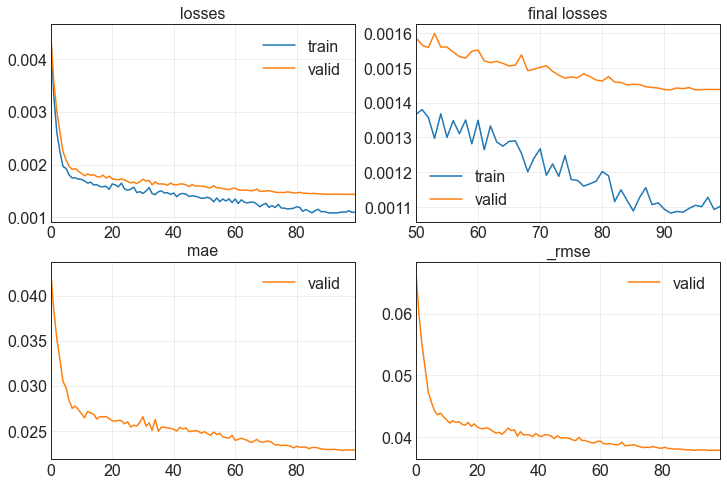

1280.4045383930206                                                                                                     
[0.0011017359793186188, 0.0014379917411133647, 0.02285444736480713, 0.03792085498571396]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 28%|██████████▋                           | 28/100 [4:11:38<21:22:39, 1068.89s/trial, best loss: 0.001435956102795899]

No improvement since epoch 52: early stopping                                                                          
 28%|██████████▋                           | 28/100 [4:41:16<21:22:39, 1068.89s/trial, best loss: 0.001435956102795899]

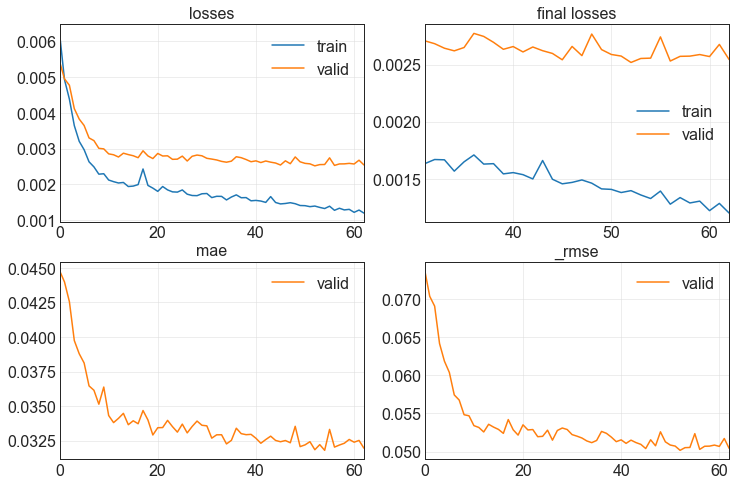

1777.6417653560638                                                                                                     
[0.0011995724635198712, 0.002543345093727112, 0.03195033222436905, 0.05043159797787666]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 29%|███████████                           | 29/100 [4:41:21<25:18:11, 1282.99s/trial, best loss: 0.001435956102795899]

No improvement since epoch 84: early stopping                                                                          
 29%|███████████                           | 29/100 [4:52:59<25:18:11, 1282.99s/trial, best loss: 0.001435956102795899]

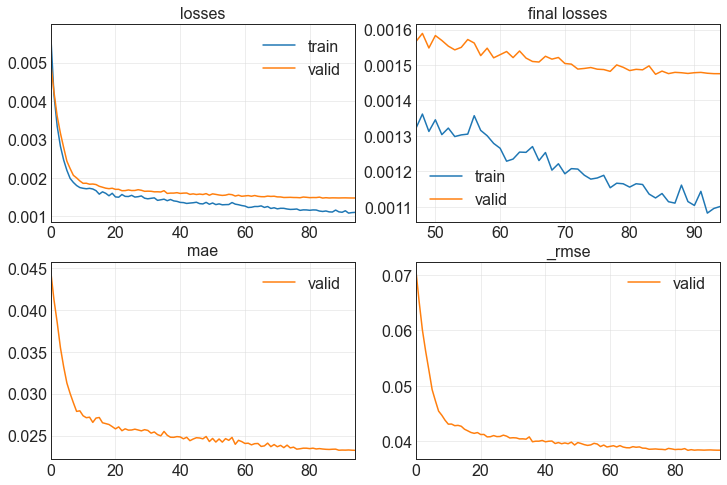

698.4499847888947                                                                                                      
[0.0011010575108230114, 0.0014756261371076107, 0.023230738937854767, 0.0384138822555542]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 30%|███████████▍                          | 30/100 [4:53:05<21:34:02, 1109.18s/trial, best loss: 0.001435956102795899]

No improvement since epoch 18: early stopping                                                                          
 30%|███████████▍                          | 30/100 [4:58:23<21:34:02, 1109.18s/trial, best loss: 0.001435956102795899]

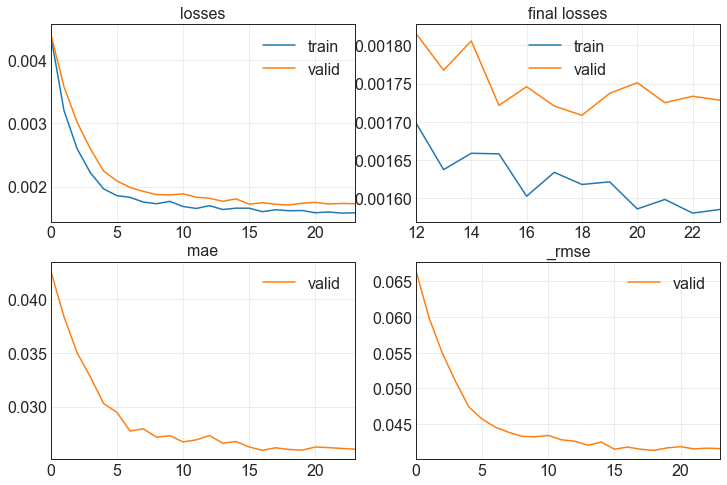

318.62052369117737                                                                                                     
[0.001585657591931522, 0.0017283011693507433, 0.026055701076984406, 0.04157285392284393]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 31%|████████████                           | 31/100 [4:58:28<16:44:31, 873.50s/trial, best loss: 0.001435956102795899]

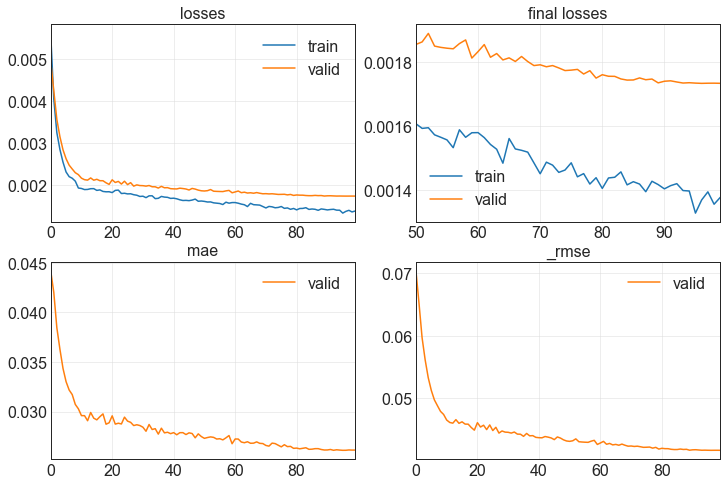

1307.9452755451202                                                                                                     
[0.0013770479708909988, 0.0017338159959763288, 0.02610662952065468, 0.04163910076022148]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 32%|████████████▏                         | 32/100 [5:20:21<18:59:20, 1005.30s/trial, best loss: 0.001435956102795899]

No improvement since epoch 33: early stopping                                                                          
 32%|████████████▏                         | 32/100 [5:27:49<18:59:20, 1005.30s/trial, best loss: 0.001435956102795899]

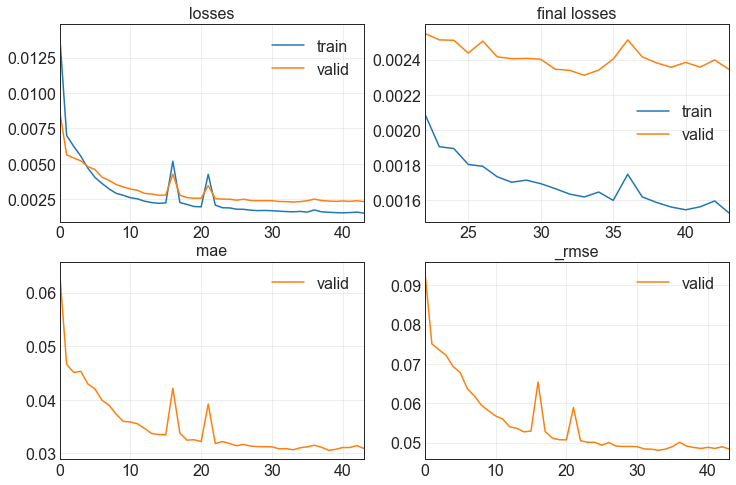

448.7205739021301                                                                                                      
[0.0015273882308974862, 0.0023435186594724655, 0.030921394005417824, 0.048409901559352875]                             
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 33%|████████████▊                          | 33/100 [5:27:55<15:37:50, 839.86s/trial, best loss: 0.001435956102795899]

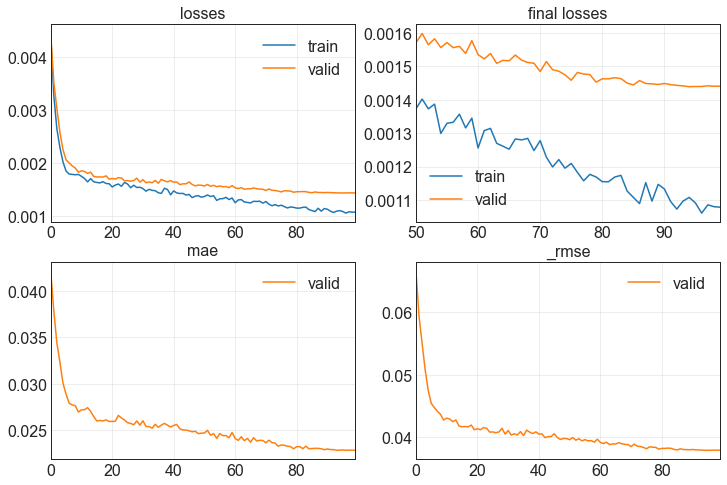

1344.6568806171417                                                                                                     
[0.0010782668832689524, 0.001440600142814219, 0.022867023944854736, 0.03795524314045906]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 34%|█████████████▎                         | 34/100 [5:50:24<18:12:02, 992.76s/trial, best loss: 0.001435956102795899]

No improvement since epoch 55: early stopping                                                                          
 34%|█████████████▎                         | 34/100 [5:55:39<18:12:02, 992.76s/trial, best loss: 0.001435956102795899]

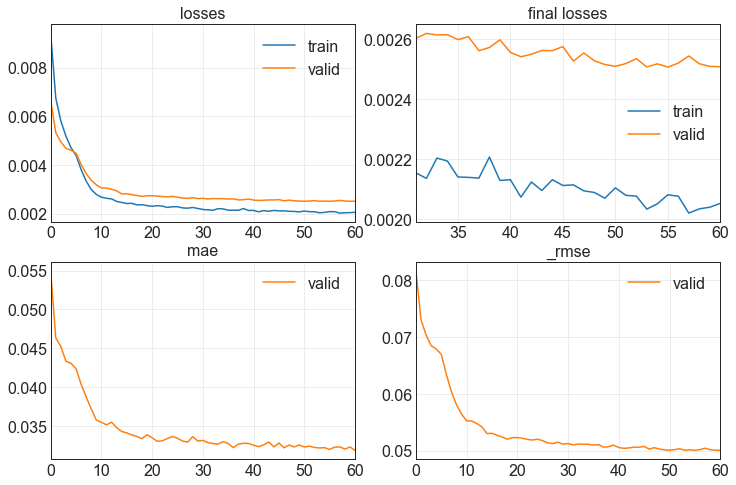

315.2547800540924                                                                                                      
[0.0020526398438960314, 0.0025074819568544626, 0.03185306489467621, 0.05007475987076759]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 35%|█████████████▋                         | 35/100 [5:55:45<14:16:56, 791.02s/trial, best loss: 0.001435956102795899]

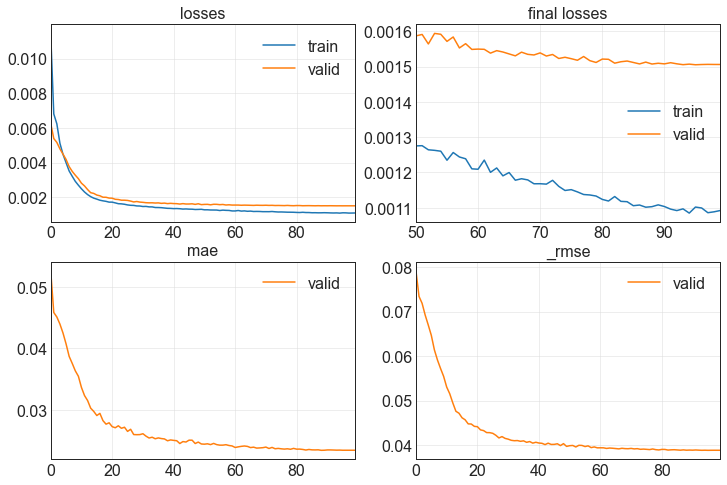

292.21571922302246                                                                                                     
[0.0010922192595899105, 0.0015059913275763392, 0.02346470020711422, 0.03880710154771805]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 36%|██████████████                         | 36/100 [6:00:42<11:25:42, 642.85s/trial, best loss: 0.001435956102795899]

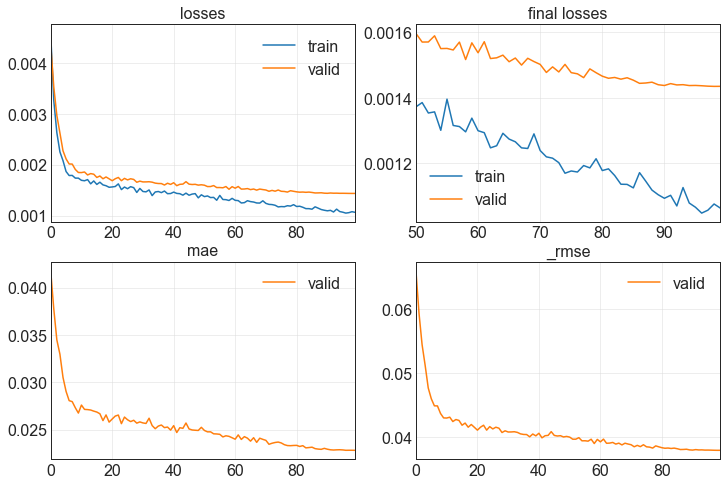

1345.5335080623627                                                                                                     
[0.0010640796972438693, 0.001435300218872726, 0.022818107157945633, 0.03788534924387932]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 37%|██████████████▍                        | 37/100 [6:23:12<14:57:52, 855.12s/trial, best loss: 0.001435300218872726]

No improvement since epoch 40: early stopping                                                                          
 37%|██████████████▍                        | 37/100 [6:31:28<14:57:52, 855.12s/trial, best loss: 0.001435300218872726]

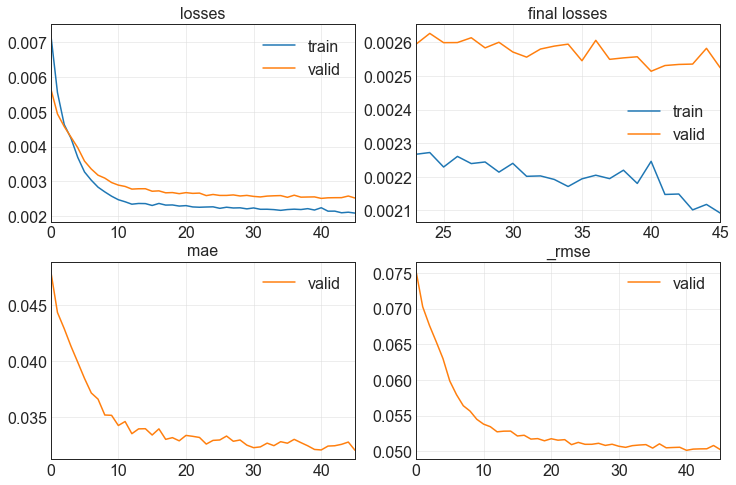

495.7089583873749                                                                                                      
[0.002092068549245596, 0.002524166600778699, 0.03207968547940254, 0.05024109408259392]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 38%|██████████████▊                        | 38/100 [6:31:33<12:53:48, 748.84s/trial, best loss: 0.001435300218872726]

No improvement since epoch 4: early stopping                                                                           
 38%|██████████████▊                        | 38/100 [6:34:03<12:53:48, 748.84s/trial, best loss: 0.001435300218872726]

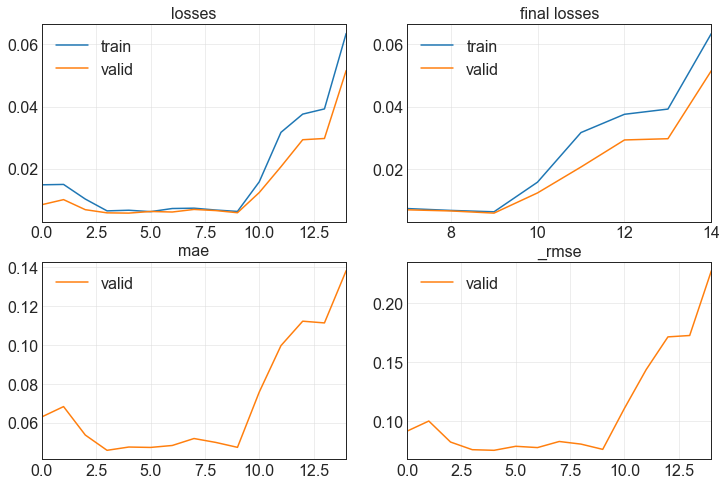

150.85233759880066                                                                                                     
[0.06353044509887695, 0.051594145596027374, 0.13823865354061127, 0.22714343667030334]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 20, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 39%|███████████████▌                        | 39/100 [6:34:09<9:40:27, 570.94s/trial, best loss: 0.001435300218872726]

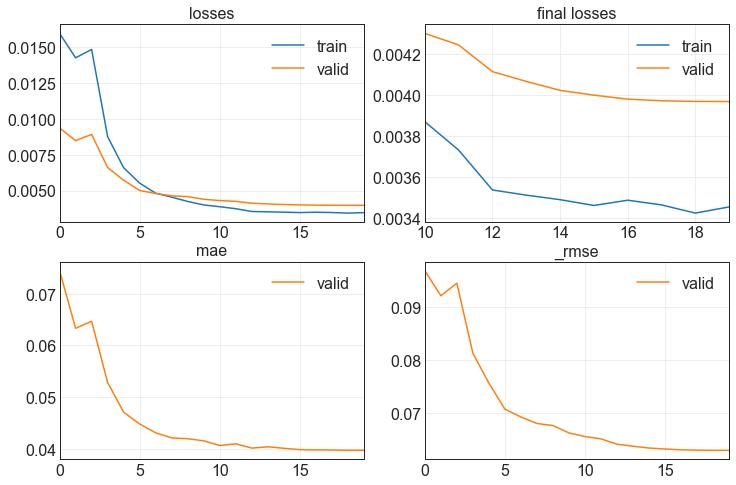

148.09639024734497                                                                                                     
[0.0034543252550065517, 0.0039679789915680885, 0.03974191099405289, 0.06299189478158951]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 40%|████████████████                        | 40/100 [6:36:42<7:25:31, 445.53s/trial, best loss: 0.001435300218872726]

No improvement since epoch 16: early stopping                                                                          
 40%|████████████████                        | 40/100 [6:46:59<7:25:31, 445.53s/trial, best loss: 0.001435300218872726]

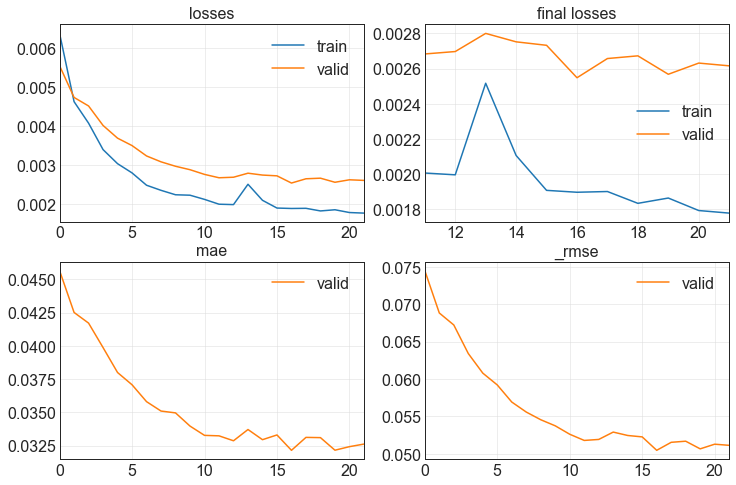

617.7264134883881                                                                                                      
[0.0017791525460779667, 0.0026153717190027237, 0.03262001648545265, 0.05114070698618889]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 41%|████████████████▍                       | 41/100 [6:47:04<8:10:22, 498.69s/trial, best loss: 0.001435300218872726]

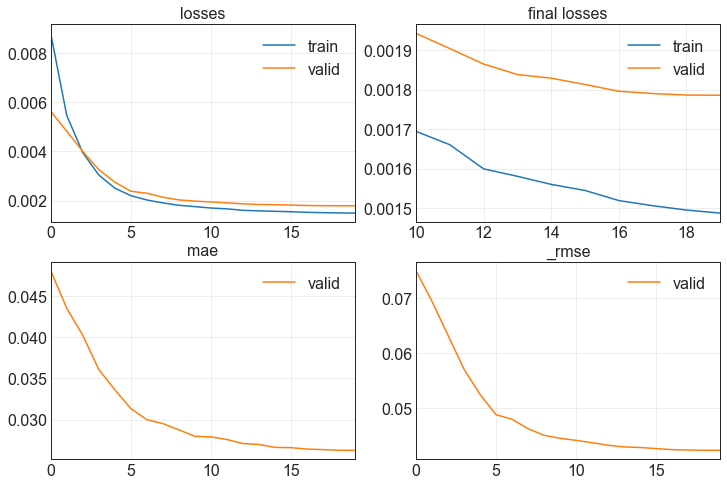

60.85572123527527                                                                                                      
[0.001486841356381774, 0.001785916043445468, 0.026273531839251518, 0.042260099202394485]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 50, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 42%|████████████████▊                       | 42/100 [6:48:11<5:56:31, 368.81s/trial, best loss: 0.001435300218872726]

No improvement since epoch 4: early stopping                                                                           
 42%|████████████████▊                       | 42/100 [6:50:54<5:56:31, 368.81s/trial, best loss: 0.001435300218872726]

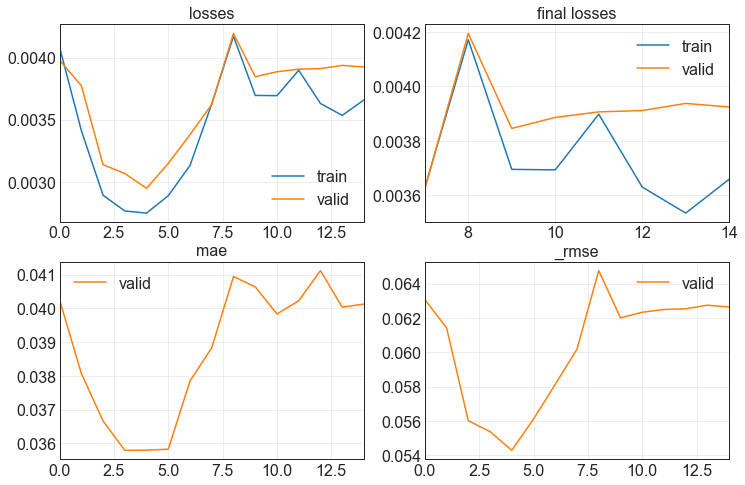

163.76980590820312                                                                                                     
[0.0036585035268217325, 0.003923829644918442, 0.04012950882315636, 0.062640480697155]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 43%|█████████████████▏                      | 43/100 [6:51:00<4:53:27, 308.91s/trial, best loss: 0.001435300218872726]

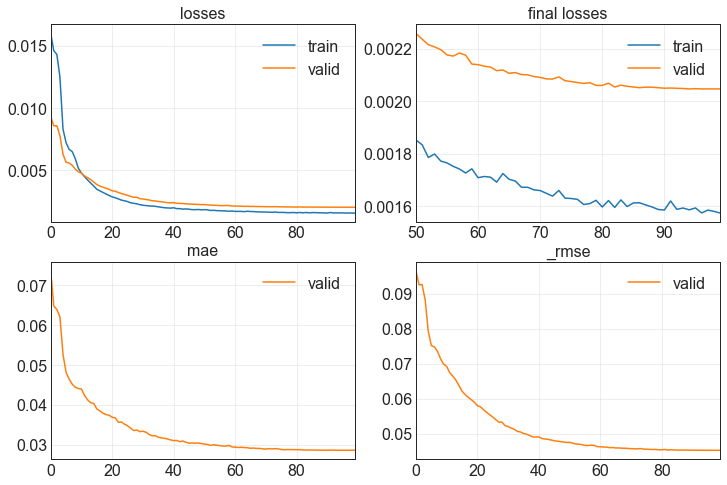

556.5869786739349                                                                                                      
[0.0015734368935227394, 0.002046226756647229, 0.028585653752088547, 0.04523523896932602]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 44%|█████████████████▌                      | 44/100 [7:00:21<5:59:04, 384.73s/trial, best loss: 0.001435300218872726]

No improvement since epoch 9: early stopping                                                                           
 44%|█████████████████▌                      | 44/100 [7:08:23<5:59:04, 384.73s/trial, best loss: 0.001435300218872726]

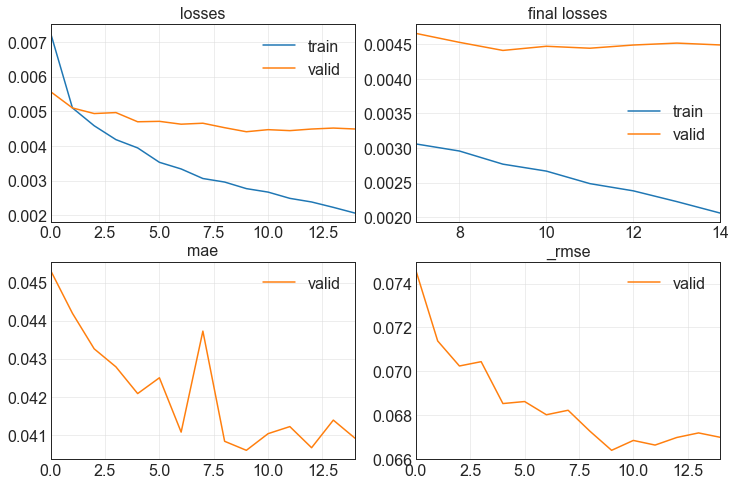

482.27188992500305                                                                                                     
[0.0020610885694622993, 0.004488334991037846, 0.040908463299274445, 0.0669950321316719]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 45%|██████████████████                      | 45/100 [7:08:28<6:20:49, 415.44s/trial, best loss: 0.001435300218872726]

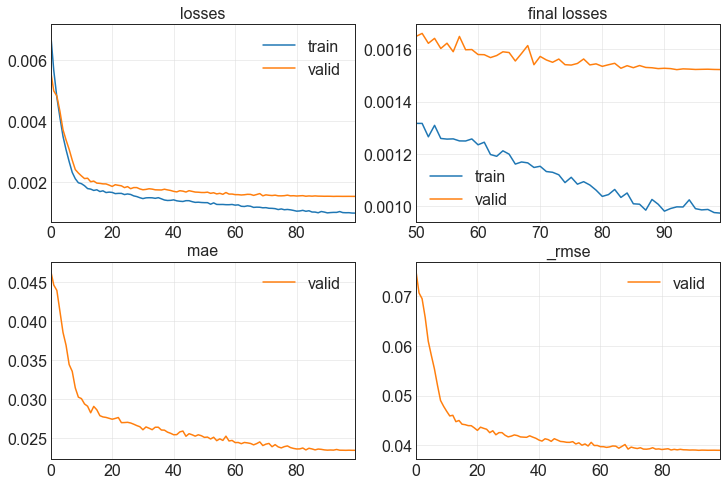

740.0058388710022                                                                                                      
[0.0009723280090838671, 0.001522935344837606, 0.023457853123545647, 0.03902481123805046]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 46%|██████████████████▍                     | 46/100 [7:20:53<7:42:48, 514.23s/trial, best loss: 0.001435300218872726]

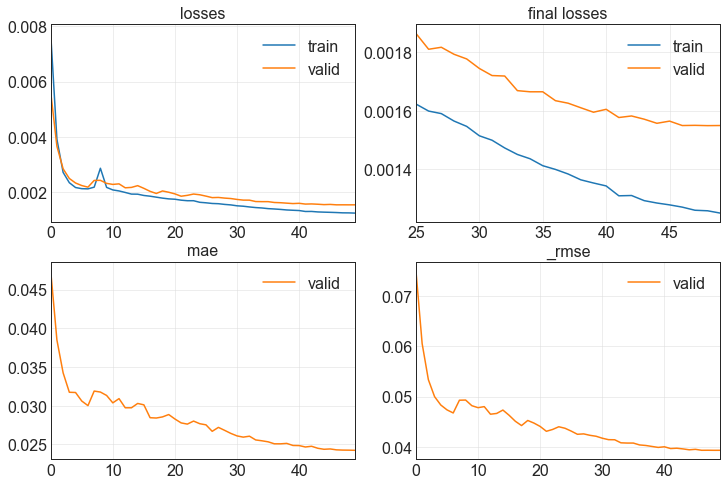

97.3596122264862                                                                                                       
[0.0012510986998677254, 0.0015497230924665928, 0.024244245141744614, 0.039366524666547775]                             
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 47%|██████████████████▊                     | 47/100 [7:22:35<5:45:03, 390.63s/trial, best loss: 0.001435300218872726]

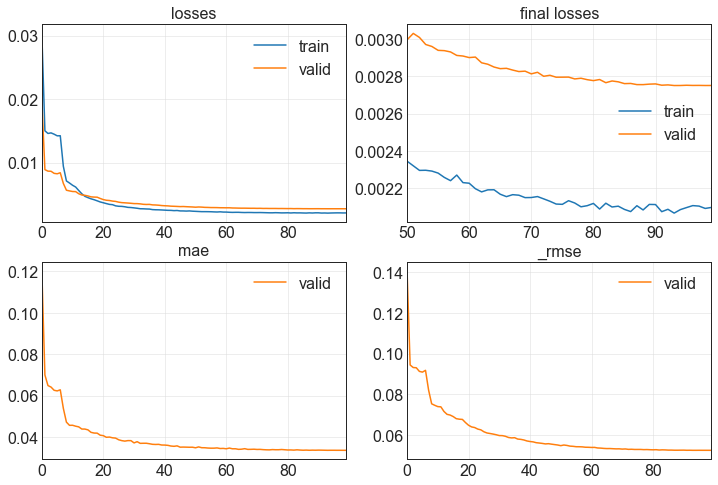

646.9031450748444                                                                                                      
[0.002096510259434581, 0.002750617219135165, 0.03368418291211128, 0.05244632437825203]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 48%|███████████████████▏                    | 48/100 [7:33:27<6:46:24, 468.94s/trial, best loss: 0.001435300218872726]

No improvement since epoch 9: early stopping                                                                           
 48%|███████████████████▏                    | 48/100 [7:38:30<6:46:24, 468.94s/trial, best loss: 0.001435300218872726]

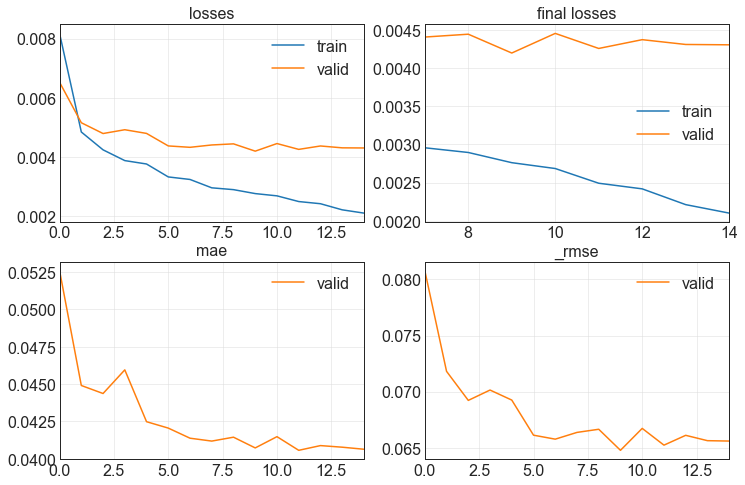

303.2270886898041                                                                                                      
[0.0021017310209572315, 0.004303891211748123, 0.040639329701662064, 0.06560405343770981]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 50, 'hidden_size': 100, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 49%|███████████████████▌                    | 49/100 [7:38:35<5:57:37, 420.74s/trial, best loss: 0.001435300218872726]

No improvement since epoch 4: early stopping                                                                           
 49%|███████████████████▌                    | 49/100 [7:44:41<5:57:37, 420.74s/trial, best loss: 0.001435300218872726]

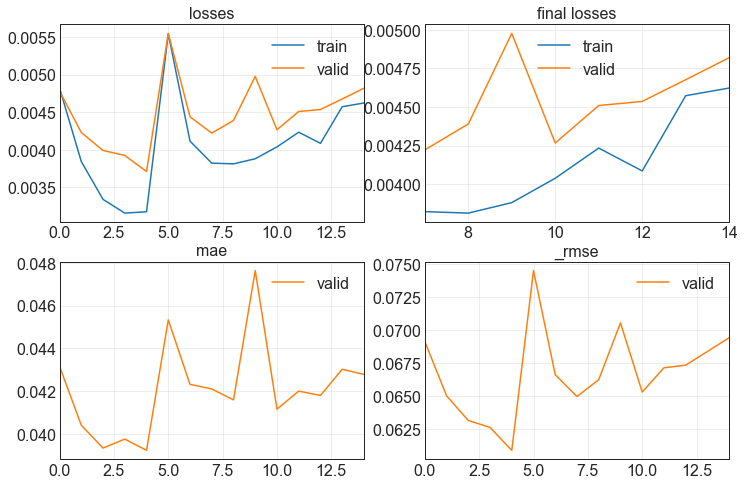

366.3829987049103                                                                                                      
[0.00462294090539217, 0.004819534718990326, 0.042789217084646225, 0.0694228783249855]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 50%|████████████████████                    | 50/100 [7:44:46<5:38:13, 405.86s/trial, best loss: 0.001435300218872726]

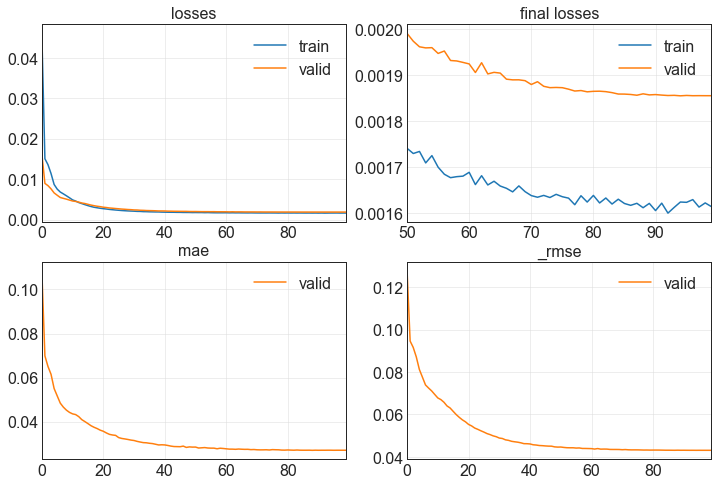

202.38159894943237                                                                                                     
[0.0016136224148795009, 0.001855033915489912, 0.026990272104740143, 0.043070100247859955]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 51%|████████████████████▍                   | 51/100 [7:48:13<4:42:46, 346.25s/trial, best loss: 0.001435300218872726]

No improvement since epoch 75: early stopping                                                                          
 51%|████████████████████▍                   | 51/100 [7:55:48<4:42:46, 346.25s/trial, best loss: 0.001435300218872726]

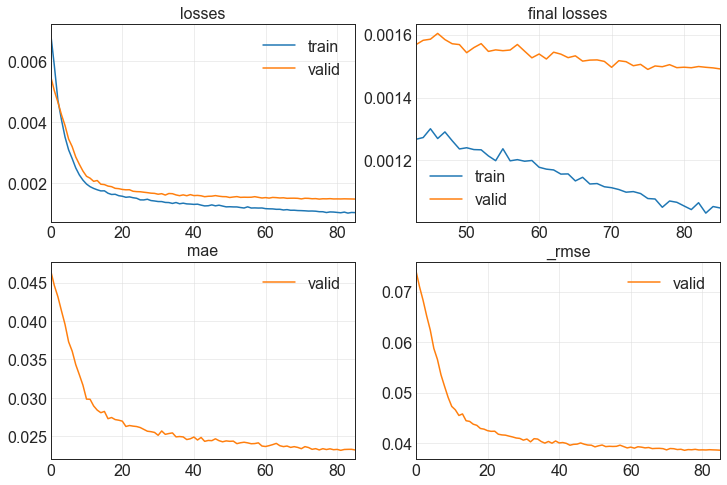

454.8481676578522                                                                                                      
[0.0010489256819710135, 0.001491102622821927, 0.0232398584485054, 0.038614802062511444]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 52%|████████████████████▊                   | 52/100 [7:55:53<5:04:11, 380.25s/trial, best loss: 0.001435300218872726]

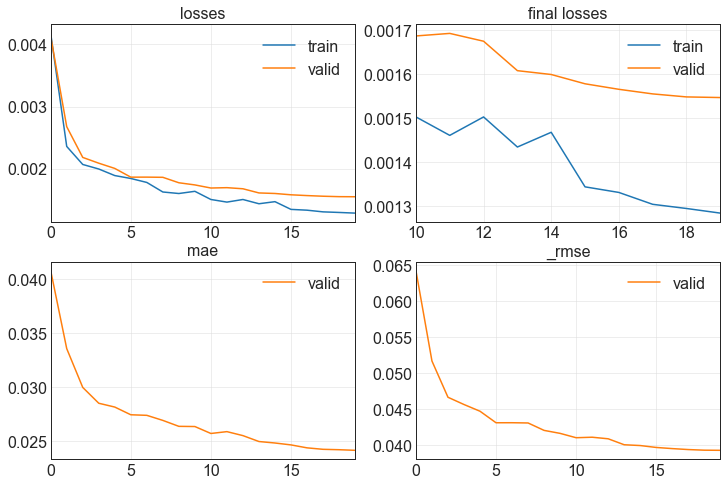

270.9027736186981                                                                                                      
[0.0012832594802603126, 0.0015467818593606353, 0.024177465587854385, 0.03932914882898331]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 53%|█████████████████████▏                  | 53/100 [8:00:28<4:33:18, 348.90s/trial, best loss: 0.001435300218872726]

No improvement since epoch 0: early stopping                                                                           
 53%|█████████████████████▏                  | 53/100 [8:04:09<4:33:18, 348.90s/trial, best loss: 0.001435300218872726]

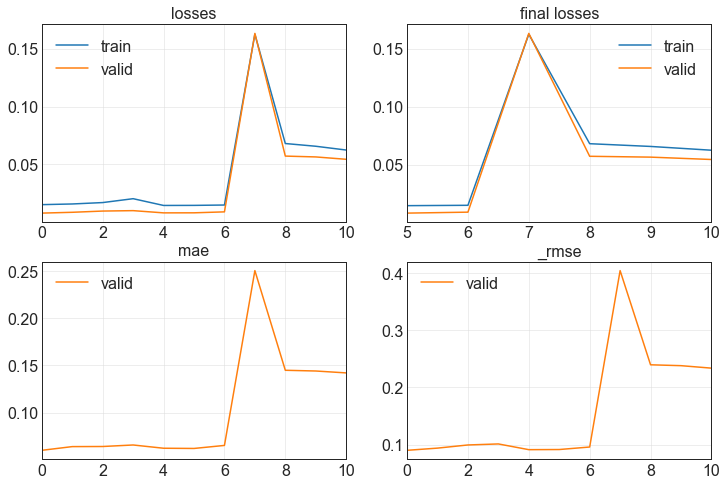

220.90809297561646                                                                                                     
[0.0624714121222496, 0.05448216199874878, 0.14210593700408936, 0.23341414332389832]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 54%|█████████████████████▌                  | 54/100 [8:04:14<3:59:08, 311.93s/trial, best loss: 0.001435300218872726]

No improvement since epoch 72: early stopping                                                                          
 54%|█████████████████████▌                  | 54/100 [8:12:44<3:59:08, 311.93s/trial, best loss: 0.001435300218872726]

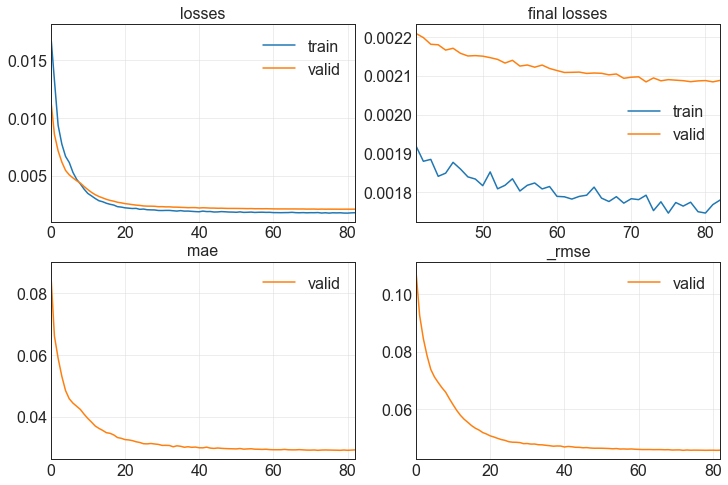

510.3492684364319                                                                                                      
[0.0017801050562411547, 0.0020879674702882767, 0.029207924380898476, 0.04569428786635399]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 55%|██████████████████████                  | 55/100 [8:12:49<4:39:39, 372.87s/trial, best loss: 0.001435300218872726]

No improvement since epoch 14: early stopping                                                                          
 55%|██████████████████████                  | 55/100 [8:22:21<4:39:39, 372.87s/trial, best loss: 0.001435300218872726]

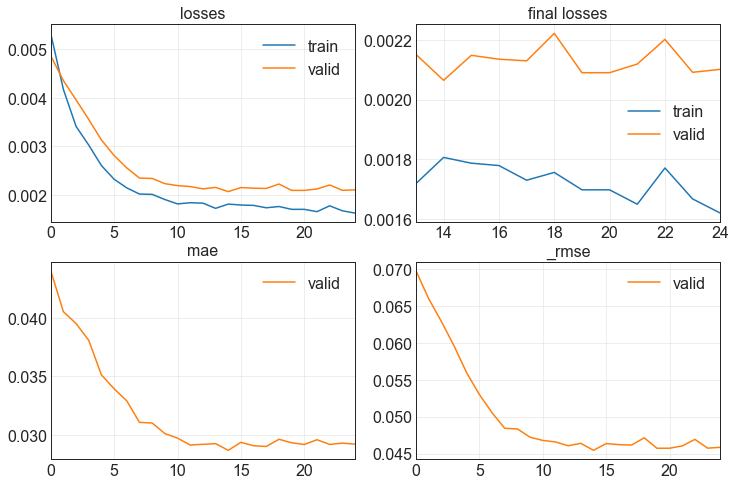

572.0397374629974                                                                                                      
[0.001620616763830185, 0.0021010106429457664, 0.02923821657896042, 0.04583678022027016]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 56%|██████████████████████▍                 | 56/100 [8:22:26<5:18:18, 434.06s/trial, best loss: 0.001435300218872726]

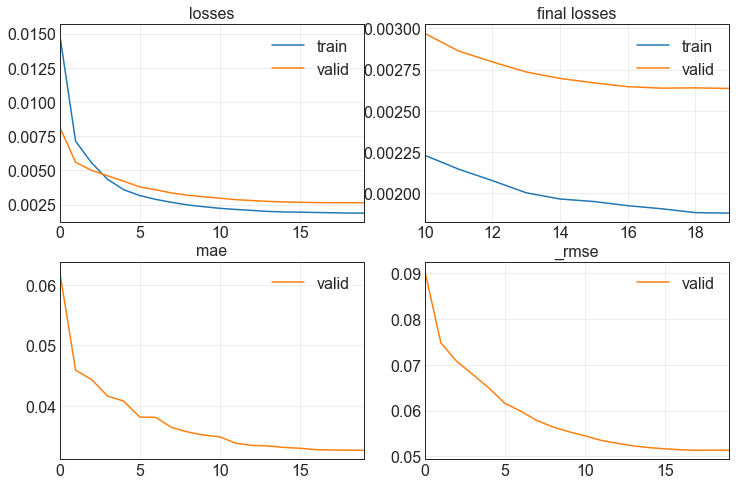

84.3683431148529                                                                                                       
[0.0018782200058922172, 0.0026358584873378277, 0.03264696151018143, 0.05134061351418495]                               
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 57%|██████████████████████▊                 | 57/100 [8:23:55<3:56:54, 330.58s/trial, best loss: 0.001435300218872726]

No improvement since epoch 74: early stopping                                                                          
 57%|██████████████████████▊                 | 57/100 [8:29:22<3:56:54, 330.58s/trial, best loss: 0.001435300218872726]

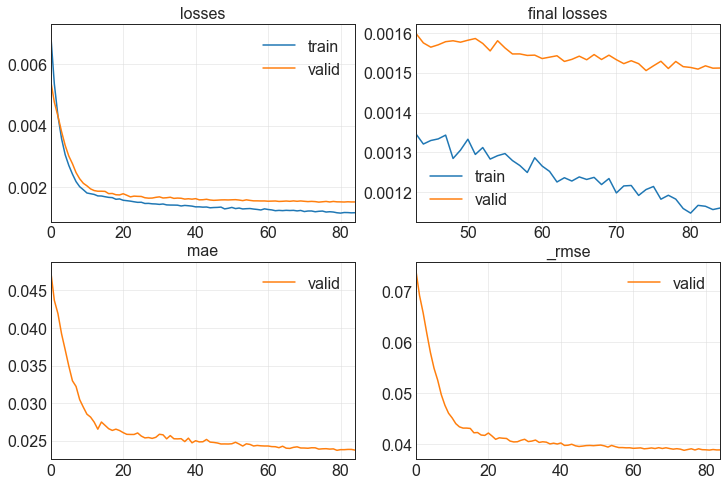

327.2713735103607                                                                                                      
[0.0011601784499362111, 0.0015117592411115766, 0.02375054359436035, 0.03888135403394699]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 58%|███████████████████████▏                | 58/100 [8:29:27<3:51:42, 331.01s/trial, best loss: 0.001435300218872726]

No improvement since epoch 4: early stopping                                                                           
 58%|███████████████████████▏                | 58/100 [8:32:15<3:51:42, 331.01s/trial, best loss: 0.001435300218872726]

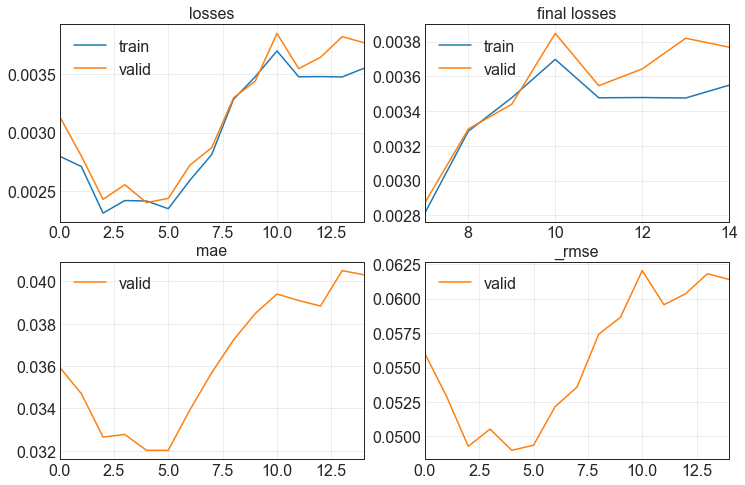

168.31004405021667                                                                                                     
[0.0035494237672537565, 0.003768410300835967, 0.040310267359018326, 0.06138737127184868]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 59%|███████████████████████▌                | 59/100 [8:32:20<3:13:49, 283.66s/trial, best loss: 0.001435300218872726]

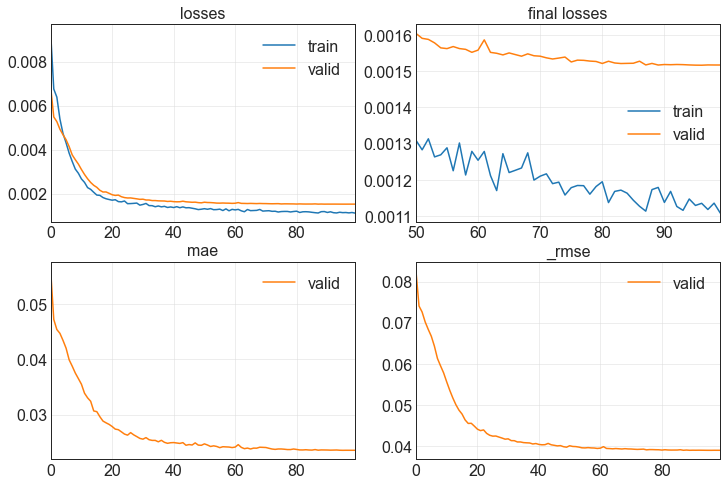

1855.888520002365                                                                                                      
[0.0011086486047133803, 0.0015168902464210987, 0.02357293665409088, 0.03894728794693947]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 60%|████████████████████████                | 60/100 [9:03:21<8:24:30, 756.76s/trial, best loss: 0.001435300218872726]

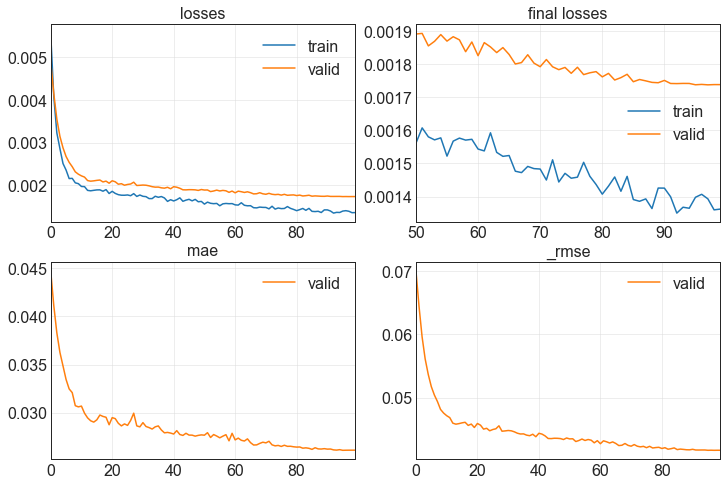

1317.4364476203918                                                                                                     
[0.0013623578706756234, 0.001737807528115809, 0.026107696816325188, 0.041687022894620895]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 61%|███████████████████████▊               | 61/100 [9:25:24<10:02:12, 926.46s/trial, best loss: 0.001435300218872726]

No improvement since epoch 22: early stopping                                                                          
 61%|███████████████████████▊               | 61/100 [9:34:21<10:02:12, 926.46s/trial, best loss: 0.001435300218872726]

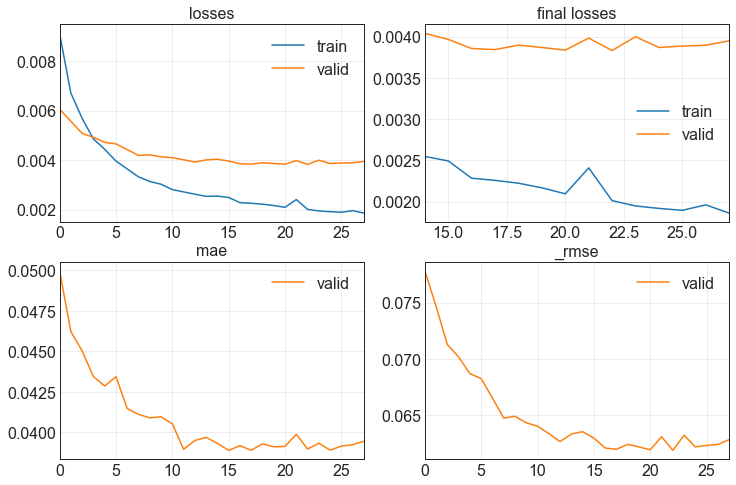

537.2639064788818                                                                                                      
[0.0018608898390084505, 0.0039481730200350285, 0.039436932653188705, 0.0628344863653183]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 62%|████████████████████████▊               | 62/100 [9:34:26<8:33:45, 811.21s/trial, best loss: 0.001435300218872726]

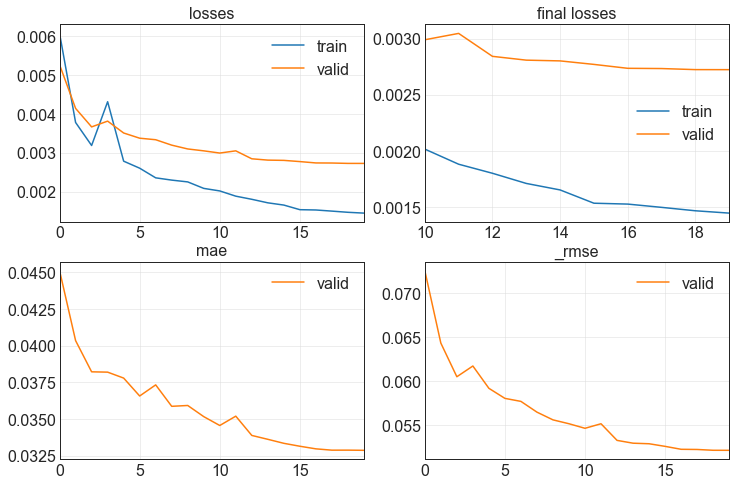

598.3731589317322                                                                                                      
[0.0014453756157308817, 0.002722871955484152, 0.03286615386605263, 0.052181147038936615]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 63%|█████████████████████████▏              | 63/100 [9:44:29<7:41:44, 748.78s/trial, best loss: 0.001435300218872726]

No improvement since epoch 10: early stopping                                                                          
 63%|█████████████████████████▏              | 63/100 [9:45:19<7:41:44, 748.78s/trial, best loss: 0.001435300218872726]

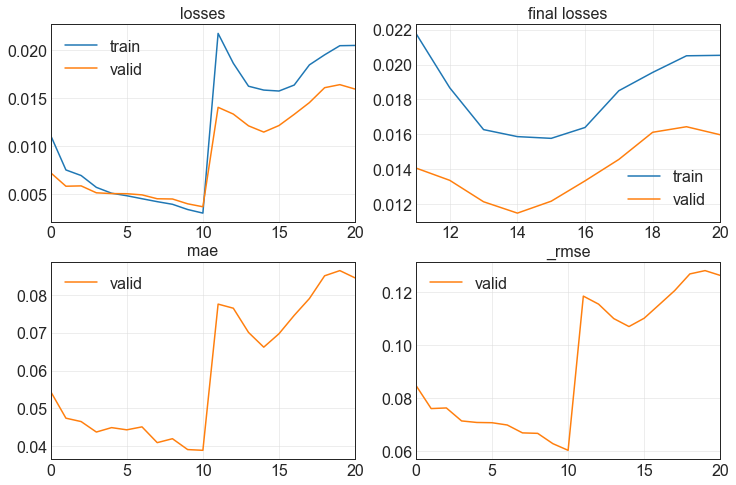

50.449872970581055                                                                                                     
[0.020527321845293045, 0.015961414203047752, 0.08446826785802841, 0.12633851170539856]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 64%|█████████████████████████▌              | 64/100 [9:45:24<5:24:25, 540.72s/trial, best loss: 0.001435300218872726]

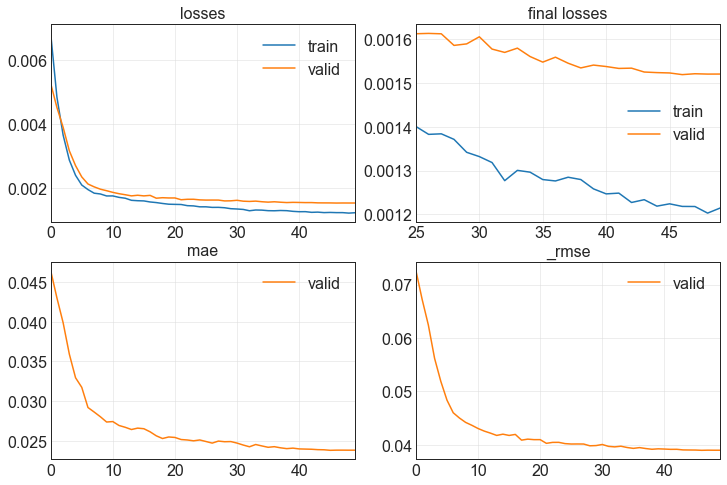

185.5668284893036                                                                                                      
[0.001214767573401332, 0.0015202783979475498, 0.02383878454566002, 0.03899074345827103]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 65%|██████████████████████████              | 65/100 [9:48:34<4:14:05, 435.59s/trial, best loss: 0.001435300218872726]

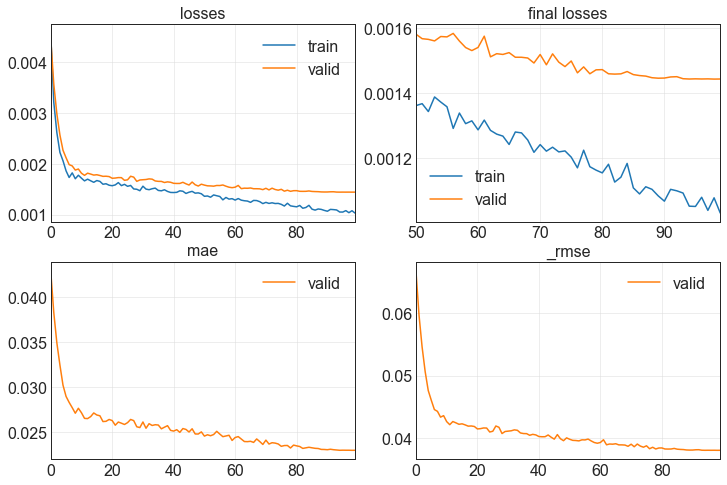

1300.563721895218                                                                                                      
[0.0010305329924449325, 0.001442932989448309, 0.02296551503241062, 0.03798595443367958]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 66%|█████████████████████████▋             | 66/100 [10:10:20<6:34:40, 696.49s/trial, best loss: 0.001435300218872726]

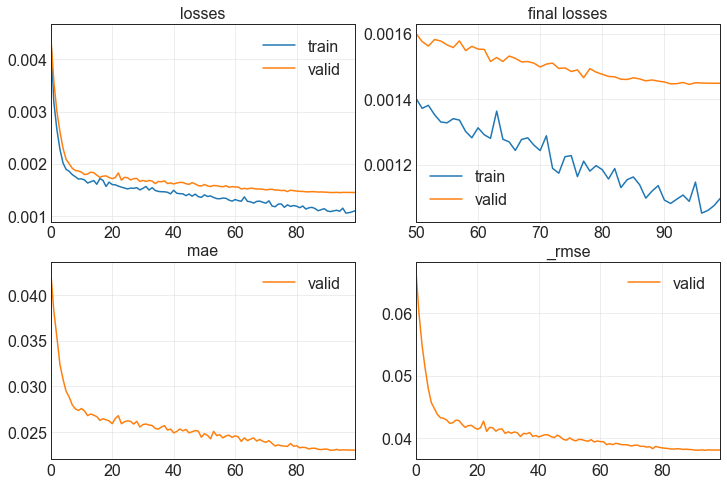

1300.1015853881836                                                                                                     
[0.0010971227893605828, 0.0014482204569503665, 0.023003073409199715, 0.03805549070239067]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 67%|██████████████████████████▏            | 67/100 [10:32:05<8:03:28, 879.06s/trial, best loss: 0.001435300218872726]

No improvement since epoch 45: early stopping                                                                          
 67%|██████████████████████████▏            | 67/100 [10:44:21<8:03:28, 879.06s/trial, best loss: 0.001435300218872726]

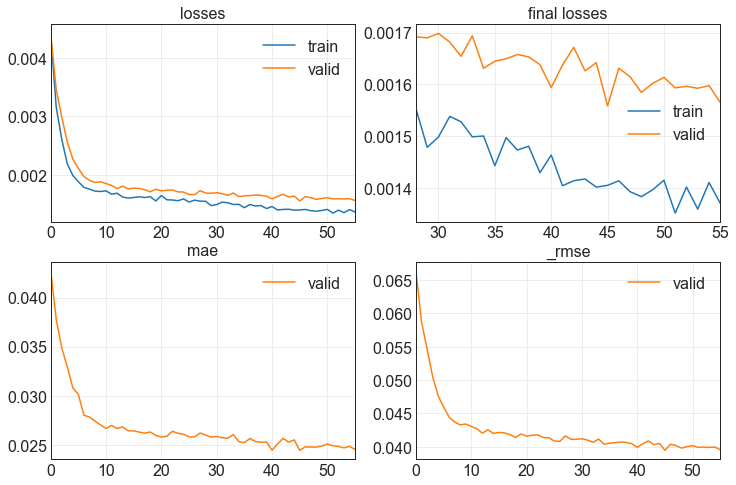

737.0979416370392                                                                                                      
[0.0013700451236218214, 0.0015650857239961624, 0.02453097142279148, 0.03956116735935211]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 68%|██████████████████████████▌            | 68/100 [10:44:27<7:26:54, 837.94s/trial, best loss: 0.001435300218872726]

No improvement since epoch 32: early stopping                                                                          
 68%|██████████████████████████▌            | 68/100 [10:53:45<7:26:54, 837.94s/trial, best loss: 0.001435300218872726]

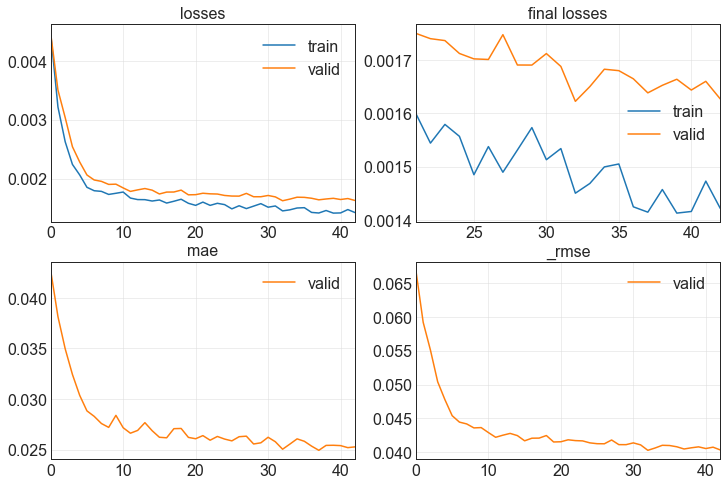

558.6868505477905                                                                                                      
[0.0014216313138604164, 0.001627183286473155, 0.02526422217488289, 0.04033835977315903]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 69%|██████████████████████████▉            | 69/100 [10:53:50<6:30:24, 755.62s/trial, best loss: 0.001435300218872726]

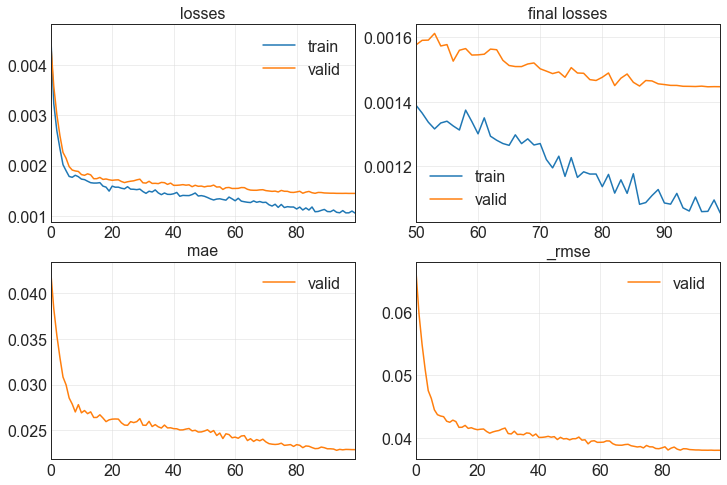

1333.5609209537506                                                                                                     
[0.001055129454471171, 0.0014468650333583355, 0.022860083729028702, 0.03803768381476402]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 70%|███████████████████████████▎           | 70/100 [11:16:09<7:45:13, 930.44s/trial, best loss: 0.001435300218872726]

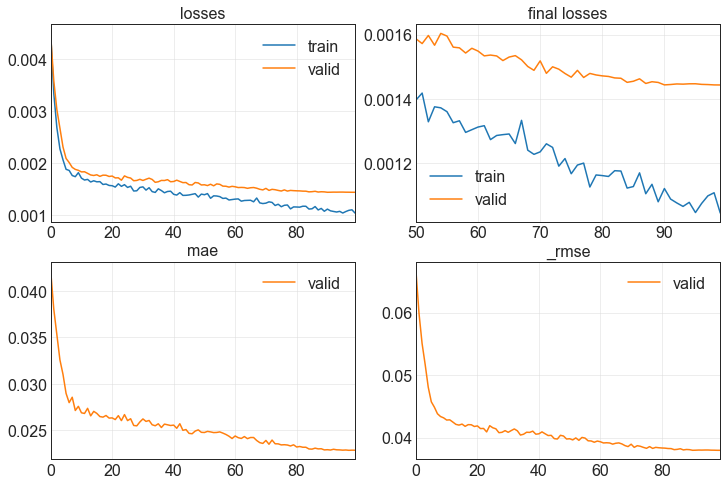

1360.5514981746674                                                                                                     
[0.001043613301590085, 0.001442890614271164, 0.02287895604968071, 0.037985410541296005]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 71%|██████████████████████████▉           | 71/100 [11:38:55<8:32:49, 1061.01s/trial, best loss: 0.001435300218872726]

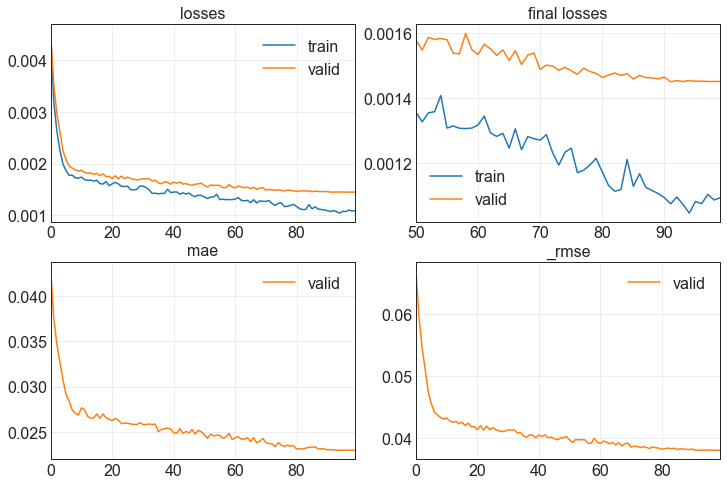

1341.327127456665                                                                                                      
[0.0010931504657492042, 0.001451296848244965, 0.02300616167485714, 0.03809588775038719]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 72%|███████████████████████████▎          | 72/100 [12:01:21<8:55:06, 1146.65s/trial, best loss: 0.001435300218872726]

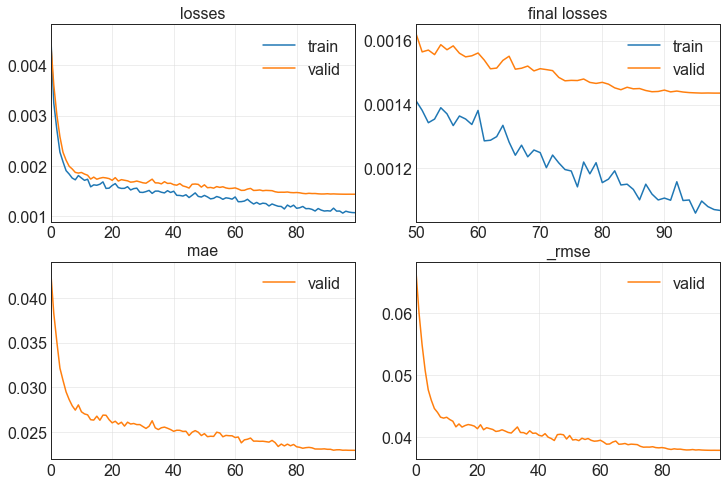

1370.3828718662262                                                                                                     
[0.0010682997526600957, 0.0014358864864334464, 0.022934552282094955, 0.03789309412240982]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 73%|███████████████████████████▋          | 73/100 [12:24:17<9:06:54, 1215.34s/trial, best loss: 0.001435300218872726]

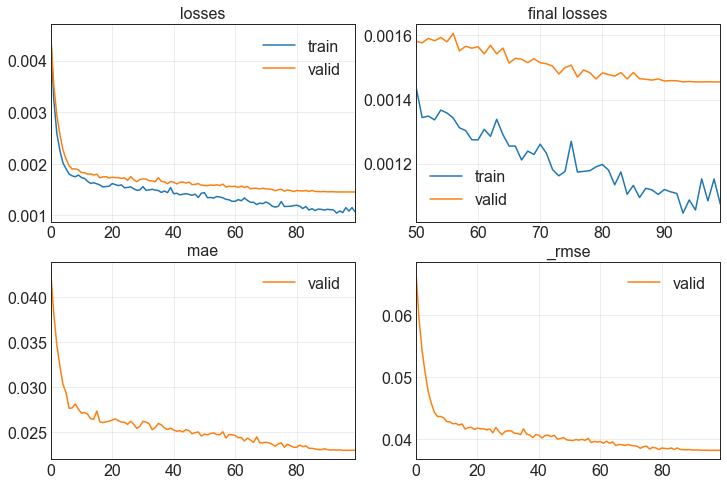

1334.8105990886688                                                                                                     
[0.00107361632399261, 0.0014550929190590978, 0.02298991195857525, 0.03814568743109703]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 74%|████████████████████████████          | 74/100 [12:46:36<9:02:49, 1252.67s/trial, best loss: 0.001435300218872726]

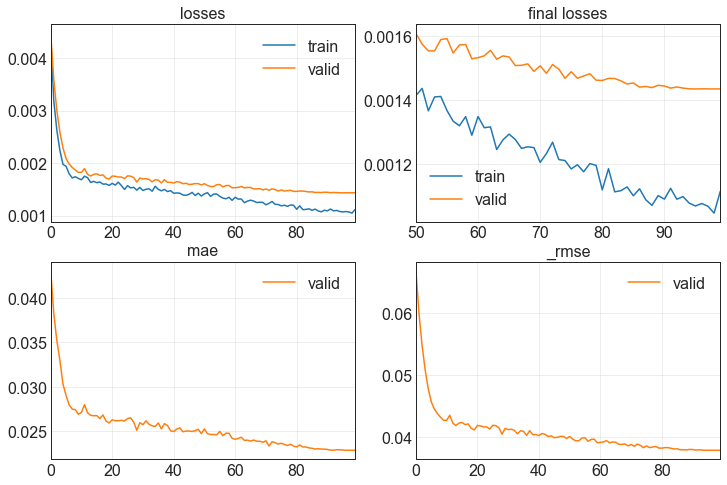

1348.227695465088                                                                                                      
[0.001115748193114996, 0.0014352878788486123, 0.02286527305841446, 0.03788519650697708]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 75%|███████████████████████████▊         | 75/100 [13:09:10<8:54:30, 1282.83s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 76: early stopping                                                                          
 75%|███████████████████████████▊         | 75/100 [13:24:23<8:54:30, 1282.83s/trial, best loss: 0.0014352878788486123]

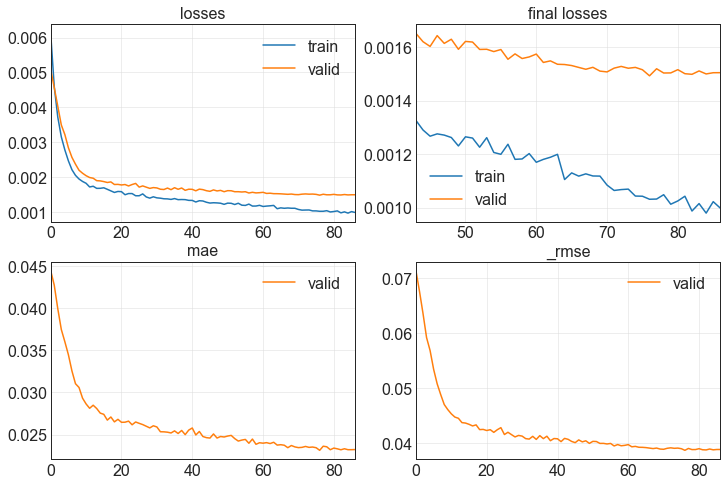

914.0201423168182                                                                                                      
[0.0009981760522350669, 0.0015042945742607117, 0.023212231695652008, 0.03878523409366608]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 76%|████████████████████████████         | 76/100 [13:24:28<7:49:29, 1173.71s/trial, best loss: 0.0014352878788486123]

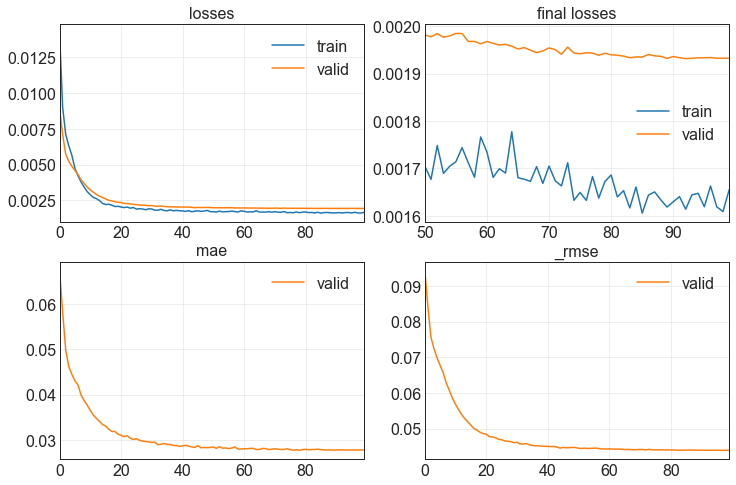

1360.7358541488647                                                                                                     
[0.001655052532441914, 0.0019322853768244386, 0.027785329148173332, 0.043957773596048355]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 77%|████████████████████████████▍        | 77/100 [13:47:15<7:51:58, 1231.25s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 16: early stopping                                                                          
 77%|████████████████████████████▍        | 77/100 [13:57:51<7:51:58, 1231.25s/trial, best loss: 0.0014352878788486123]

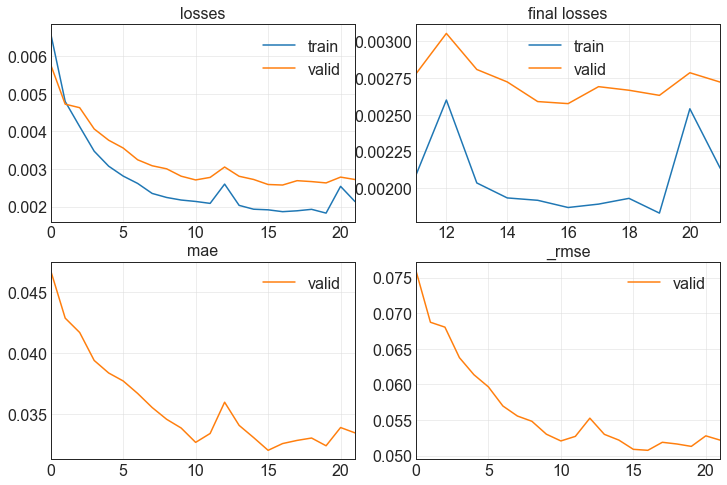

636.5504930019379                                                                                                      
[0.002134871669113636, 0.002722165547311306, 0.03347870707511902, 0.05217438191175461]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 78%|████████████████████████████▊        | 78/100 [13:57:56<6:26:39, 1054.51s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 52: early stopping                                                                          
 78%|████████████████████████████▊        | 78/100 [14:03:17<6:26:39, 1054.51s/trial, best loss: 0.0014352878788486123]

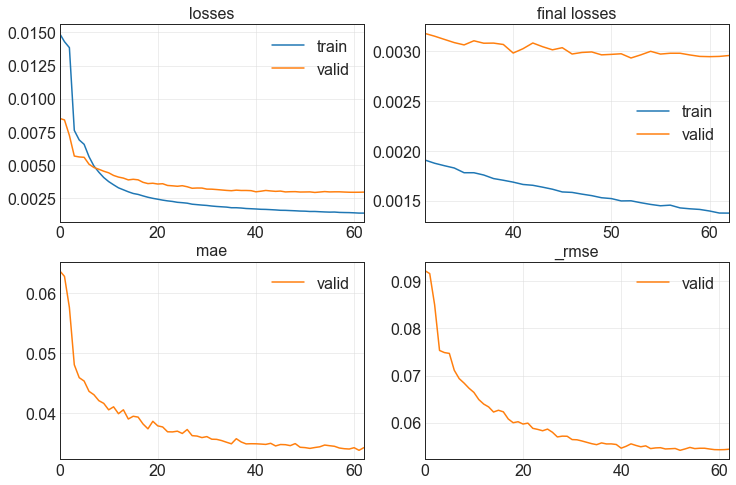

321.4516921043396                                                                                                      
[0.0013737414265051484, 0.002956084441393614, 0.034237172454595566, 0.05436987802386284]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 79%|██████████████████████████████        | 79/100 [14:03:22<4:52:37, 836.07s/trial, best loss: 0.0014352878788486123]

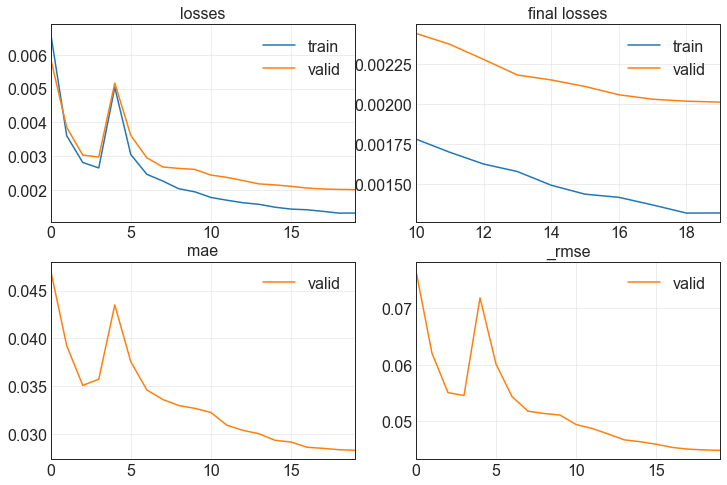

308.3377778530121                                                                                                      
[0.0013183379778638482, 0.0020125543233007193, 0.02830992452800274, 0.044861502945423126]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 80%|██████████████████████████████▍       | 80/100 [14:08:36<3:46:23, 679.19s/trial, best loss: 0.0014352878788486123]

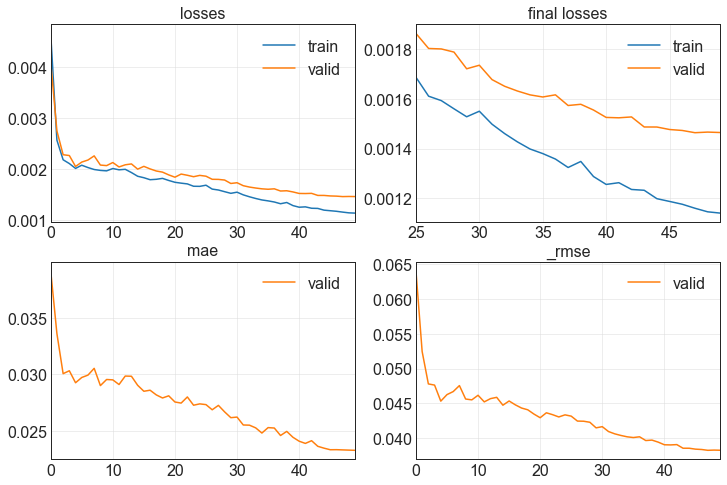

186.62120962142944                                                                                                     
[0.0011402613017708063, 0.001464744796976447, 0.023303957656025887, 0.03827197849750519]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 81%|██████████████████████████████▊       | 81/100 [14:11:47<2:48:43, 532.84s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 52: early stopping                                                                          
 81%|██████████████████████████████▊       | 81/100 [14:24:29<2:48:43, 532.84s/trial, best loss: 0.0014352878788486123]

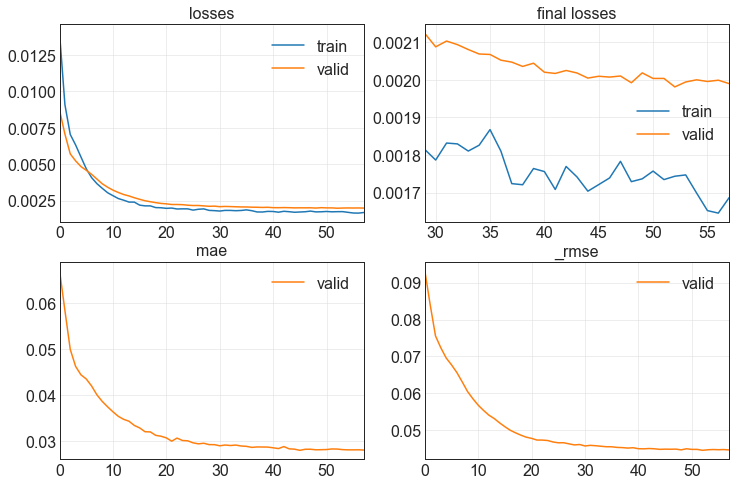

762.3678576946259                                                                                                      
[0.0016868783859536052, 0.001989758340641856, 0.028094809502363205, 0.04460670426487923]                               
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 82%|███████████████████████████████▏      | 82/100 [14:24:34<3:00:56, 603.12s/trial, best loss: 0.0014352878788486123]

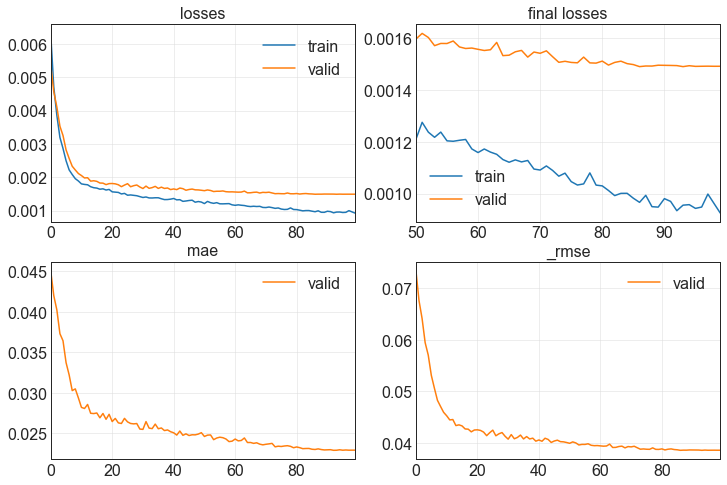

1075.88889503479                                                                                                       
[0.0009244696702808142, 0.001492181560024619, 0.02291378565132618, 0.03862876072525978]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 83%|███████████████████████████████▌      | 83/100 [14:42:35<3:31:29, 746.46s/trial, best loss: 0.0014352878788486123]

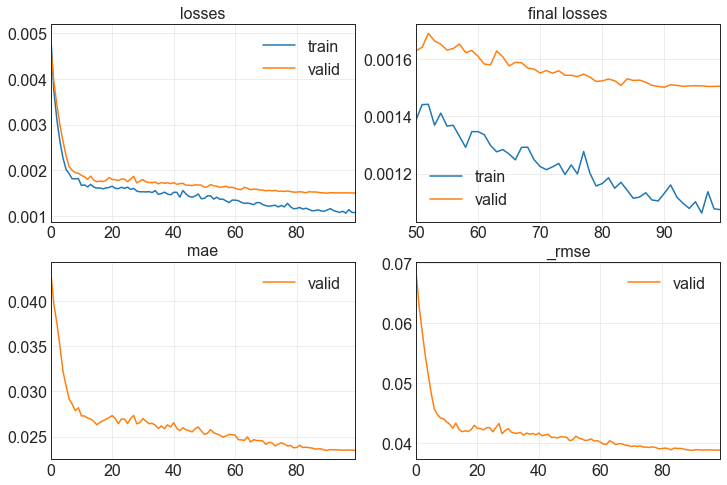

1113.4012694358826                                                                                                     
[0.0010742591693997383, 0.0015044341562315822, 0.023490015417337418, 0.03878703713417053]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 84%|███████████████████████████████▉      | 84/100 [15:01:14<3:48:48, 858.03s/trial, best loss: 0.0014352878788486123]

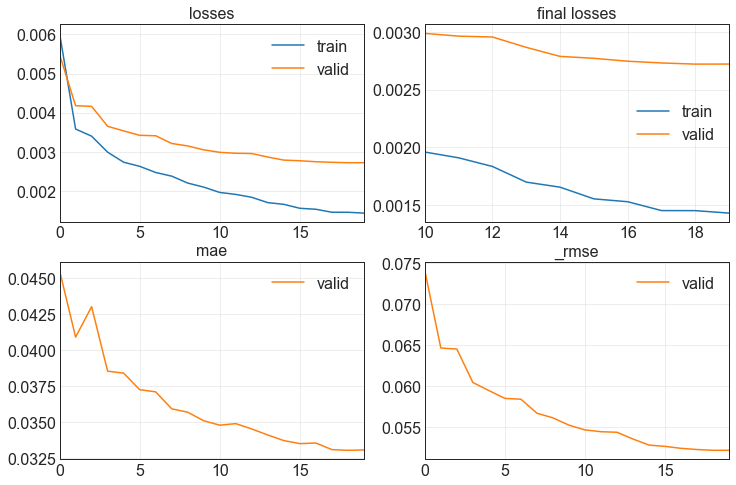

605.255268573761                                                                                                       
[0.0014329697005450726, 0.002721168799325824, 0.03304445743560791, 0.05216482654213905]                                
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 85%|████████████████████████████████▎     | 85/100 [15:11:24<3:15:55, 783.70s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 14: early stopping                                                                          
 85%|████████████████████████████████▎     | 85/100 [15:13:39<3:15:55, 783.70s/trial, best loss: 0.0014352878788486123]

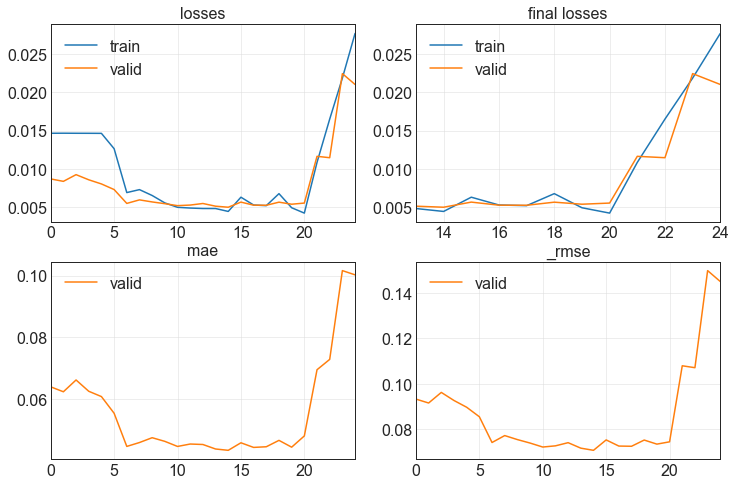

135.67461347579956                                                                                                     
[0.027698921039700508, 0.021027451381087303, 0.10021716356277466, 0.14500845968723297]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': True, 'epochs': 50, 'hidden_size': 50, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 86%|████████████████████████████████▋     | 86/100 [15:13:44<2:17:50, 590.74s/trial, best loss: 0.0014352878788486123]

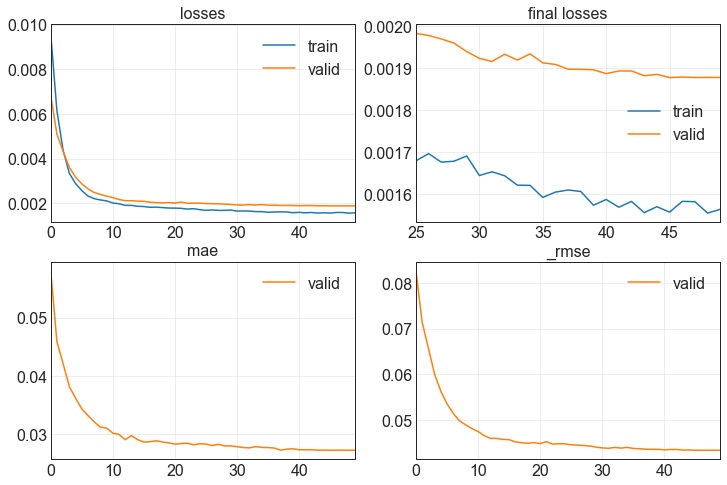

174.32875752449036                                                                                                     
[0.00156371109187603, 0.0018775819335132837, 0.02725759893655777, 0.043331071734428406]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.001, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 87%|█████████████████████████████████     | 87/100 [15:16:43<1:41:14, 467.25s/trial, best loss: 0.0014352878788486123]

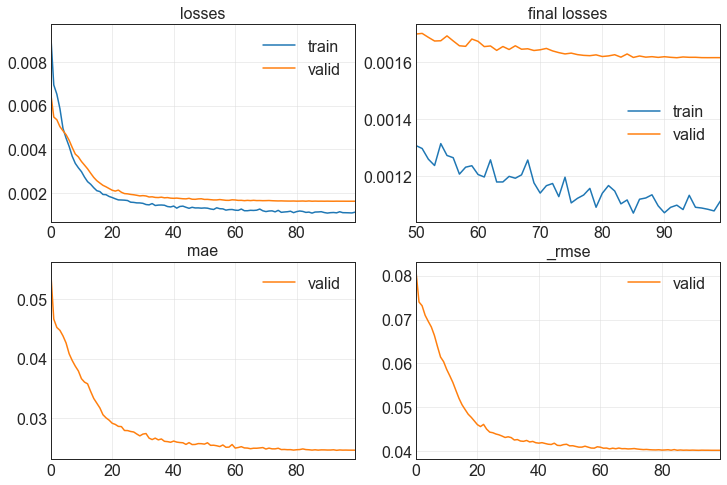

2315.4874408245087                                                                                                     
[0.0011118827387690544, 0.001614681095816195, 0.024545367807149887, 0.04018310084939003]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 88%|████████████████████████████████▌    | 88/100 [15:55:24<3:24:38, 1023.23s/trial, best loss: 0.0014352878788486123]

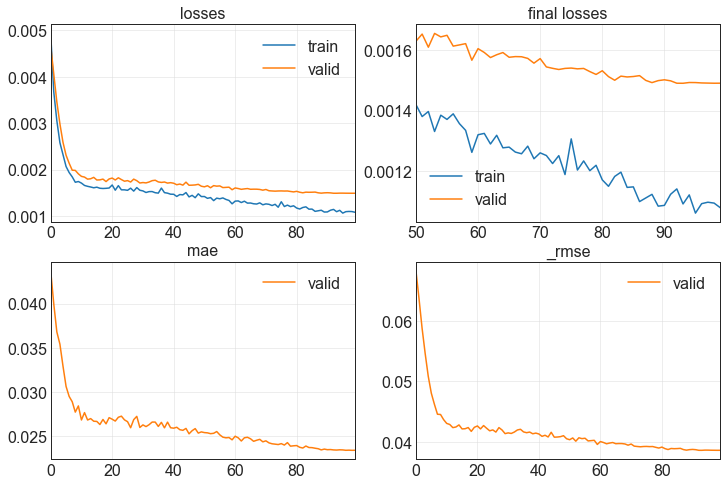

1055.2758202552795                                                                                                     
[0.0010800256859511137, 0.001490301452577114, 0.02341718226671219, 0.03860442340373993]                                
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 100, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 89%|████████████████████████████████▉    | 89/100 [16:13:04<3:09:37, 1034.33s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 87: early stopping                                                                          
 89%|████████████████████████████████▉    | 89/100 [16:22:59<3:09:37, 1034.33s/trial, best loss: 0.0014352878788486123]

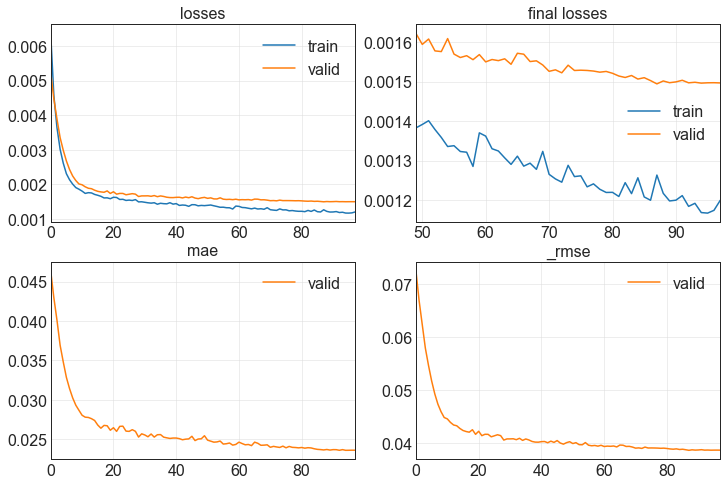

595.1076059341431                                                                                                      
[0.0011995872482657433, 0.0014966771705076098, 0.023589741438627243, 0.03868690878152847]                              
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 90%|██████████████████████████████████▏   | 90/100 [16:23:04<2:30:40, 904.04s/trial, best loss: 0.0014352878788486123]

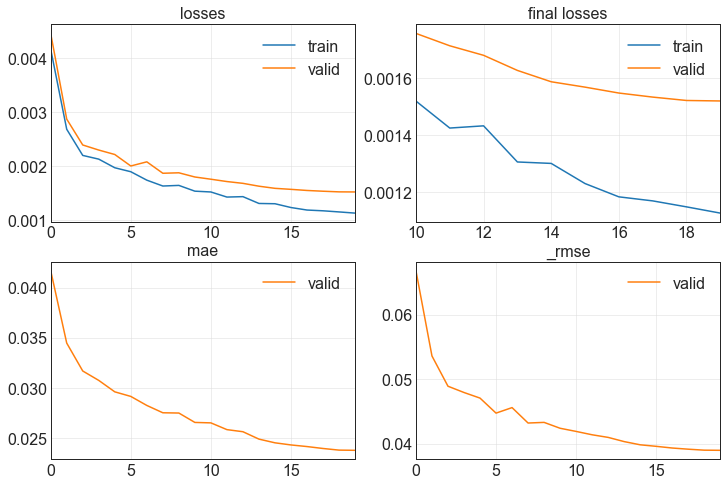

357.5705270767212                                                                                                      
[0.0011259347666054964, 0.0015190053964033723, 0.02374234050512314, 0.03897440806031227]                               
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 50, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 91%|██████████████████████████████████▌   | 91/100 [16:29:06<1:51:13, 741.54s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 5: early stopping                                                                           
 91%|██████████████████████████████████▌   | 91/100 [16:29:38<1:51:13, 741.54s/trial, best loss: 0.0014352878788486123]

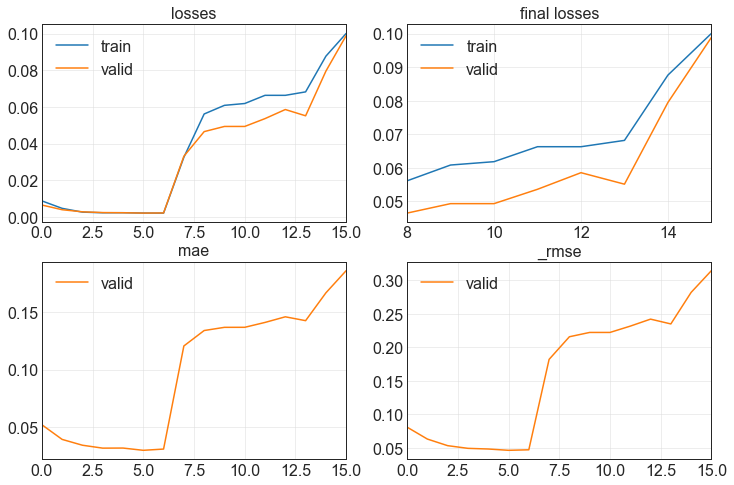

32.388474225997925                                                                                                     
[0.10006630420684814, 0.09888517111539841, 0.18642929196357727, 0.3144601285457611]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 4, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 92%|██████████████████████████████████▉   | 92/100 [16:29:43<1:10:41, 530.21s/trial, best loss: 0.0014352878788486123]

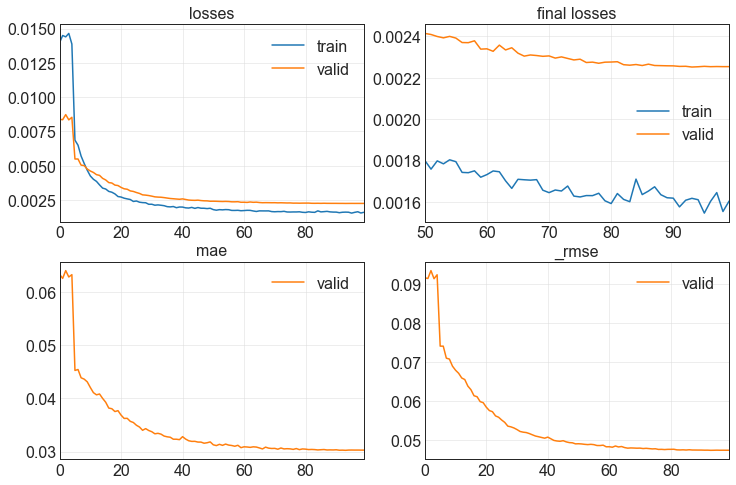

2652.3195428848267                                                                                                     
[0.0016057476168498397, 0.002253847662359476, 0.030300403013825417, 0.047474704682826996]                              
Trying params:                                                                                                         
{'batch_size': 64, 'bidirectional': False, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 93%|██████████████████████████████████▍  | 93/100 [17:14:01<2:16:17, 1168.25s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 22: early stopping                                                                          
 93%|██████████████████████████████████▍  | 93/100 [17:17:17<2:16:17, 1168.25s/trial, best loss: 0.0014352878788486123]

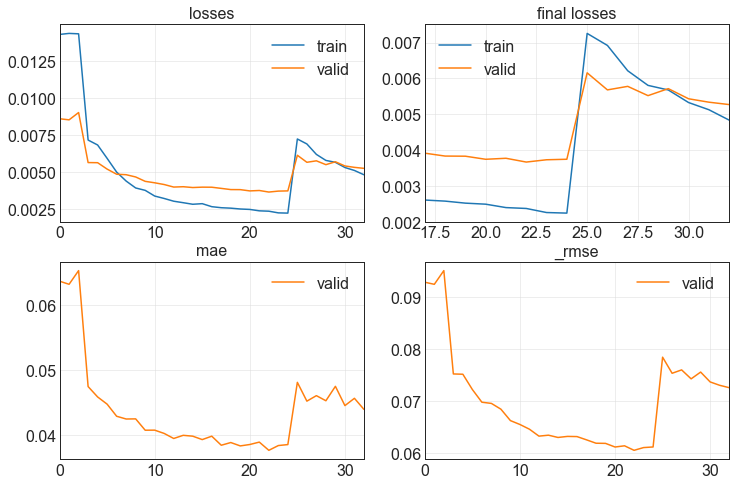

196.9857017993927                                                                                                      
[0.004837242886424065, 0.0052707805298268795, 0.04398953169584274, 0.07260013371706009]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 3, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 94%|███████████████████████████████████▋  | 94/100 [17:17:22<1:27:50, 878.36s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 78: early stopping                                                                          
 94%|███████████████████████████████████▋  | 94/100 [17:50:50<1:27:50, 878.36s/trial, best loss: 0.0014352878788486123]

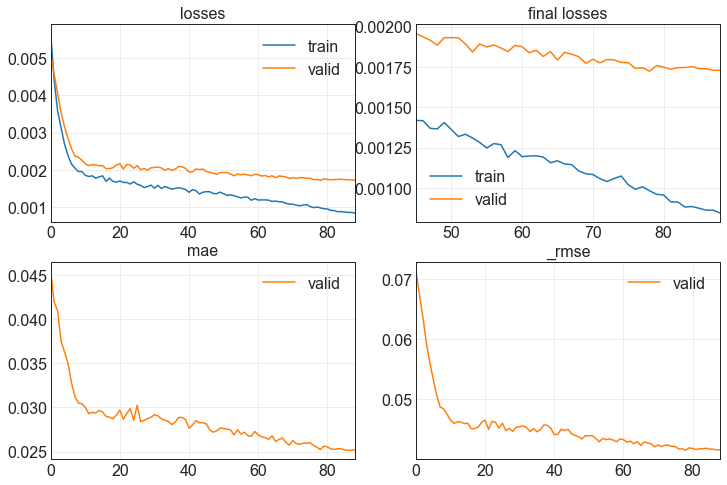

2007.7329189777374                                                                                                     
[0.0008445526473224163, 0.0017305577639490366, 0.025200210511684418, 0.04159998893737793]                              
Trying params:                                                                                                         
{'batch_size': 32, 'bidirectional': True, 'epochs': 20, 'hidden_size': 100, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 5}
GRU                                                                                                                    
 95%|███████████████████████████████████▏ | 95/100 [17:50:55<1:41:32, 1218.59s/trial, best loss: 0.0014352878788486123]

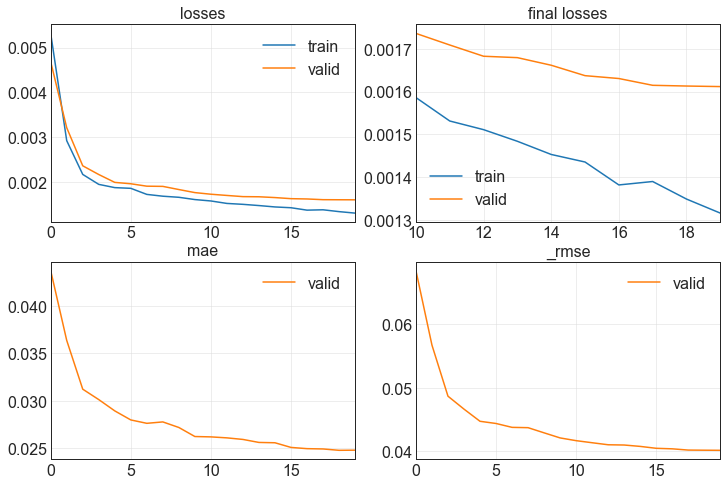

121.42303013801575                                                                                                     
[0.0013159746304154396, 0.001611726125702262, 0.024809226393699646, 0.04014631360769272]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.1, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 96%|██████████████████████████████████████▍ | 96/100 [17:53:01<59:23, 890.89s/trial, best loss: 0.0014352878788486123]

No improvement since epoch 5: early stopping                                                                           
 96%|██████████████████████████████████████▍ | 96/100 [17:56:23<59:23, 890.89s/trial, best loss: 0.0014352878788486123]

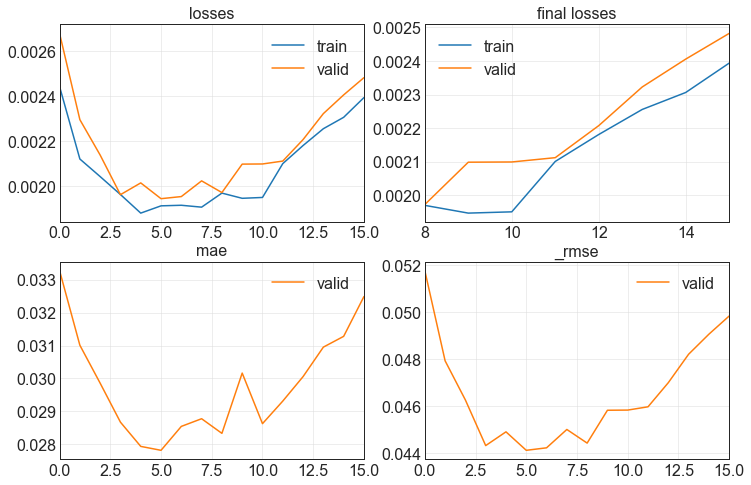

202.60210752487183                                                                                                     
[0.002393682487308979, 0.002482207026332617, 0.03248675540089607, 0.049821753054857254]                                
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': False, 'epochs': 50, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 97%|██████████████████████████████████████▊ | 97/100 [17:56:28<34:17, 685.81s/trial, best loss: 0.0014352878788486123]

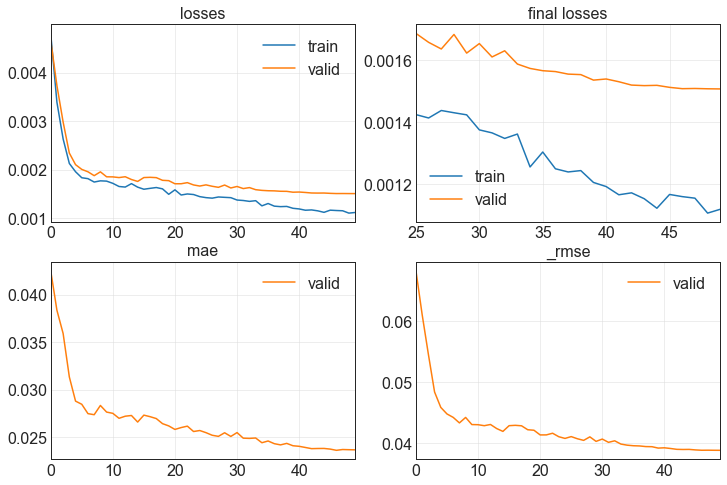

515.792026758194                                                                                                       
[0.0011178842978551984, 0.0015074079856276512, 0.023670703172683716, 0.03882535547018051]                              
Trying params:                                                                                                         
{'batch_size': 128, 'bidirectional': True, 'epochs': 100, 'hidden_size': 50, 'lr': 0.001, 'n_layers': 2, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 98%|███████████████████████████████████████▏| 98/100 [18:05:09<21:12, 636.21s/trial, best loss: 0.0014352878788486123]

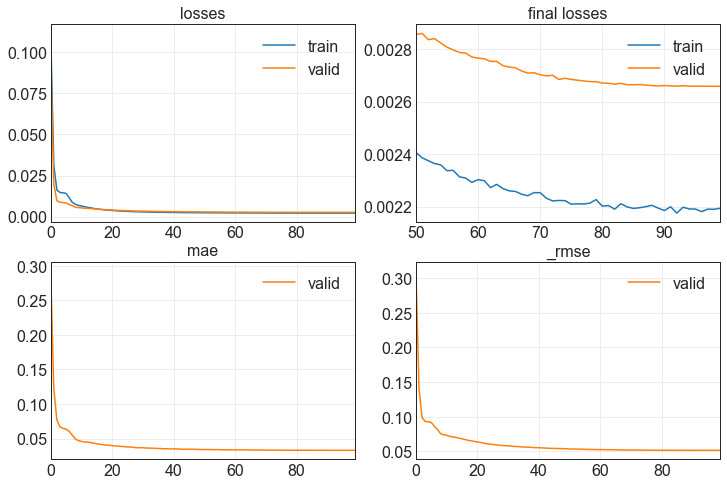

222.84052515029907                                                                                                     
[0.0021940029691904783, 0.0026584838051348925, 0.03312580659985542, 0.05156048387289047]                               
Trying params:                                                                                                         
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}
GRU                                                                                                                    
 99%|███████████████████████████████████████▌| 99/100 [18:08:56<08:33, 513.63s/trial, best loss: 0.0014352878788486123]

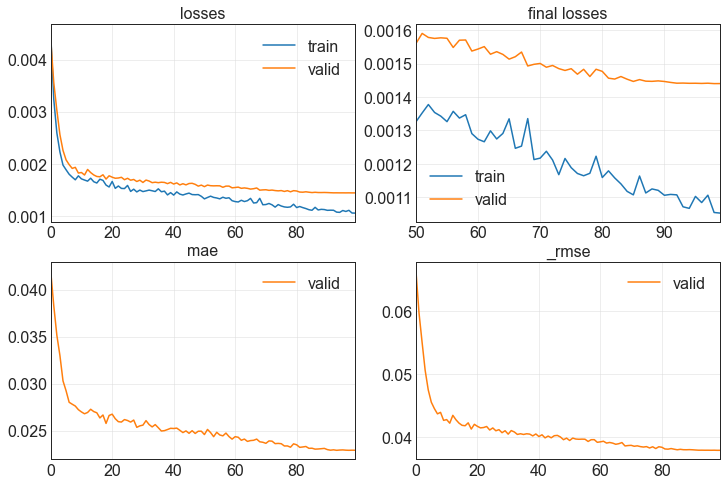

1270.1056818962097                                                                                                     
[0.0010521505028009415, 0.0014403475215658545, 0.022902075201272964, 0.03795190900564194]                              
100%|███████████████████████████████████████| 100/100 [18:30:07<00:00, 666.07s/trial, best loss: 0.0014352878788486123]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 16, 'bidirectional': True, 'epochs': 100, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 1, 'optimizer': <function Adam at 0x000002A7C8E97438>, 'patience': 10}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(38467, 144, 10)

In [62]:
y.shape

(38467, 144)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = GRU
k = {
    'n_layers': params['n_layers'],
    'hidden_size': params['hidden_size'],
    'bidirectional': params['bidirectional']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

GRU


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): GRU(
    (rnn): GRU(144, 200, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=400, out_features=144, bias=True)
  )
  (1): Sigmoid()
)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

472,944 total parameters.
472,944 training parameters.


Training the model:

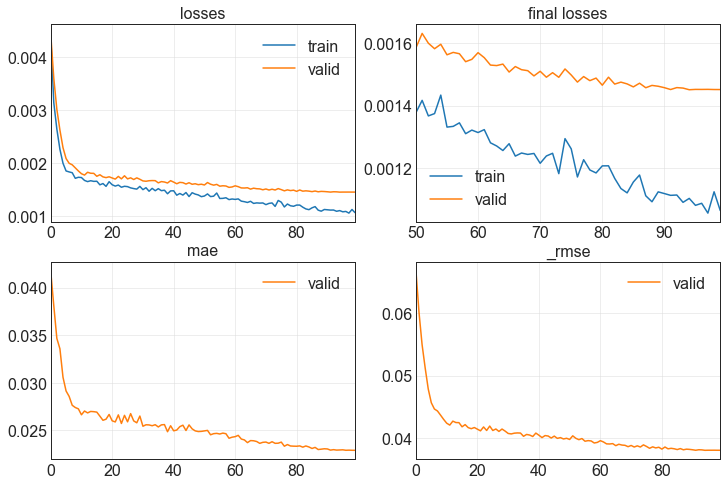

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

9619


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.0033, 0.0128, 0.0224,  ..., 0.0200, 0.2249, 0.9289],
         [0.0050, 0.0109, 0.0243,  ..., 0.0209, 0.1876, 0.8817],
         [0.0033, 0.0143, 0.0245,  ..., 0.0221, 0.2005, 0.8401],
         ...,
         [0.4055, 0.0384, 0.1546,  ..., 0.0912, 0.3843, 0.9764],
         [0.3677, 0.0330, 0.1417,  ..., 0.0970, 0.3717, 0.9669],
         [0.3767, 0.0338, 0.1708,  ..., 0.1063, 0.3814, 0.9479]]),
 tensor([[0.0000, 0.0020, 0.0167,  ..., 0.0065, 0.2165, 0.8989],
         [0.0000, 0.0040, 0.0109,  ..., 0.0057, 0.2154, 0.7845],
         [0.0000, 0.0020, 0.0082,  ..., 0.0079, 0.2064, 1.0000],
         ...,
         [0.6255, 0.0400, 0.1464,  ..., 0.0790, 0.4122, 0.8162],
         [0.6294, 0.0634, 0.2009,  ..., 0.0886, 0.4169, 0.7650],
         [0.4050, 0.0551, 0.1543,  ..., 0.0931, 0.3980, 0.9314]]),
 tensor([[0.0033, 0.0128, 0.0224,  ..., 0.0200, 0.2249, 0.9289],
         [0.0050, 0.0109, 0.0243,  ..., 0.0209, 0.1876, 0.8817],
         [0.0033, 0.0143, 0.0245,  ..., 0.0221, 0.2005, 0.

In [73]:
test_targets.shape

torch.Size([9619, 144])

In [74]:
test_preds.shape

torch.Size([9619, 144])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(9619, 1, 144)

In [78]:
y_pred.shape

(9619, 1, 144)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(9619, 1, 144)

In [83]:
y_pred.shape

(9619, 1, 144)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  1277.2809369564056
Test time (in seconds):  2.181201219558716


In [91]:
print('Training time (in seconds) per epoch: ', 1277.2809369564056 / 100)

Training time (in seconds) per epoch:  12.772809369564056


Calculate the RMSE and MAE for differnt time steps:

In [87]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  8.085804201890257
MAE:  3.807606289778334


Plot the RMSE and MAE distributions for each time step:

In [88]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [89]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

GRU_TM-minmax_RMSE-10-1-step-1.pdf
GRU_TM-minmax_MAE-10-1-step-1.pdf


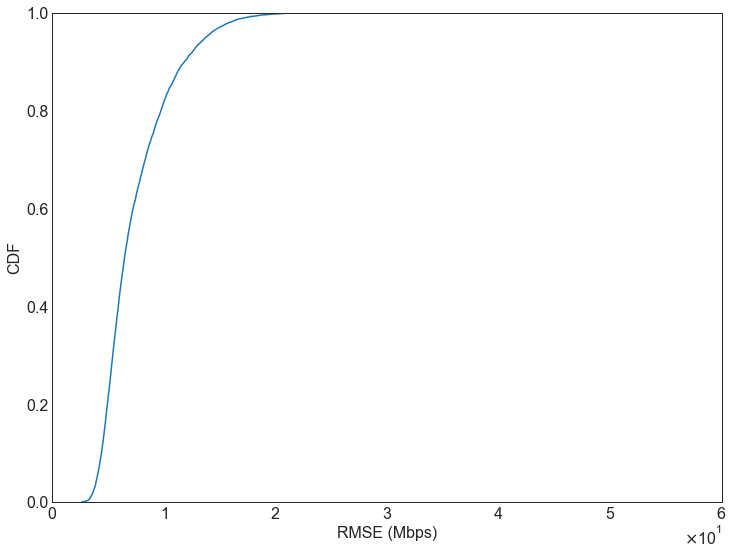

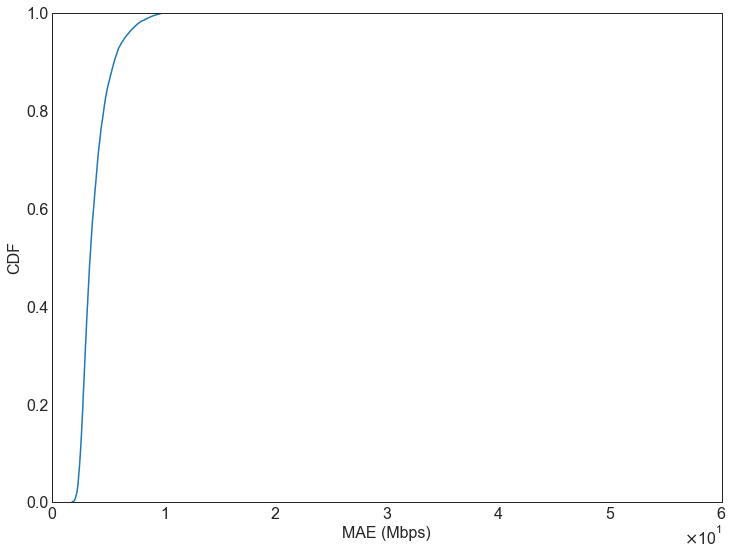

In [90]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)